On se propose dans ce mini-projet d'entrainer plusieurs modèles pour la tâche de *sentiment analysis* sur le dataset IMDB.

In [49]:
## Library imports
import random
import os
import re
import string
import time
import requests
import tarfile

import pandas as pd
import numpy as np
import numpy.random as rd
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

from bs4 import BeautifulSoup
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import torch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, LSTM, GRU, Flatten, BatchNormalization, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from google.colab import drive

!pip install optuna
import optuna



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
drive.mount('/content/drive', force_remount=True)

cuda
Mounted at /content/drive


# Presentation de l'étude

## Tâche de Sentiment Analysis

La *sentiment analysis* est une tâche qui consiste à identifier et classer les émotions, opinions ou attitudes exprimées dans un texte, critiques, séquences textuellse. Le principe est de tenter de prédire si une séquenvce de texte exprime un sentiment positif ou négatif (ou parfois neutre, selon les cas).

Dans le cadre de ce projet, la *sentiment analysis* appliquée aux critiques de films du dataset IMDb sont utilisées afin d'entraîner plusieurs modèles capables de prédire le sentiment derrière ces critiques, en se basant uniquement sur le texte.

## Présentation du jeu de données IMDB

IMDB est un jeu de données pour la classification binaire des sentiments. Il fournit un ensemble de 25 000 critiques de films pour l'entraînement et 25 000 pour les tests. Des données non étiquetées supplémentaires sont également disponibles. Les formats de texte brut et de sac de mots déjà traités sont fournis.

Ces critiques sont organisées en deux catégories principales : positives et négatives, permettant une classification binaire des sentiments.

Les critiques d'entraînement et de test sont équilibrées, contenant chacune un nombre égal de critiques positives et négatives.

Les critiques varient en longueur, allant de quelques phrases à plusieurs paragraphes, les longueurs des séquences de textes sont donc relativement variables.


### Chargement du dataset

In [4]:
# URL du dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Nom du fichier d'archive
archive_name = "aclImdb_v1.tar.gz"
dataset_folder = "data"

# Fonction pour télécharger le fichier
def download_dataset(url, archive_name):
    if not os.path.exists(archive_name):
        print("Téléchargement en cours...")
        response = requests.get(url, stream=True)
        with open(archive_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Fichier téléchargé : {archive_name}")
    else:
        print(f"Le fichier {archive_name} existe déjà.")

# Fonction pour extraire le fichier
def extract_dataset(archive_name, extract_path):
    if not os.path.exists(extract_path):
        print("Extraction en cours...")
        with tarfile.open(archive_name, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"Dataset extrait dans le dossier : {extract_path}")
    else:
        print(f"Le dossier {extract_path} existe déjà.")

# Télécharger et extraire le dataset
download_dataset(url, archive_name)
extract_dataset(archive_name, dataset_folder)

Le fichier aclImdb_v1.tar.gz existe déjà.
Le dossier data existe déjà.


In [5]:
# Fonction pour charger les données
def load_imdb_data(data_dir):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']: # label: (1 -> positif) | (0 -> négatif)
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return texts, labels


# Chargement des données d'entraînement et de test

dataset_folder = "data/aclImdb"

# Chemins vers les dossiers contenant les données
train_dir = os.path.join(dataset_folder, "train")
test_dir = os.path.join(dataset_folder, "test")


train_texts, train_labels = load_imdb_data(train_dir)
test_texts, test_labels = load_imdb_data(test_dir)

# Transformation en DataFrame pandas
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})


In [6]:
from IPython.display import display

display(test_df.head())
display(train_df.head())


,text,label
0,And thus was born the most amorous skunk ever ...,1
1,Simply the best and most realistic movie about...,1
2,"Ah, how refreshing to see a vision of 18th cen...",1
3,"When I first rented Batman Returns, I immediat...",1
4,Two things can happen when an ensemble cast is...,1


,text,label
0,All Dogs Go To Heaven is on a par with Watersh...,1
1,"Excellent farce! Which, of course, is all it i...",1
2,The film starts in the Long Island Kennel Club...,1
3,"We stumbled upon the documentary, Grey Gardens...",1
4,This was the best documentary I've ever seen!!...,1


In [7]:
# Exemple complets:
display(train_df[train_df['label']==0]['text'].iloc[0]) # negatif
display(train_df[train_df['label']==1]['text'].iloc[0]) # positif


"A film as bad as this should be withdrawn from all stores world wide. So full of boring, dull, unimaginative characters, and with a lead character with such an annoying attitude and dry voice constantly giving a thoughtless voice over for every action and feeling, this film holds the record for the most challenging film I have ever watched. As I had payed money to own it, I felt a duty to see it through, and how I regret it. My head hurt throughout because of the terribly dull characters and their pointless, plot less lives. A bunch of kids who have zero knowledge about anything, are all frigid and worst of all, have terrible dialogue throughout, just mulling around as the main character tries to get a date with the girl. Boring, so much so my friend was shaking with hatred and I was red with embarrassment that I'd thrown away £6. The DVD was on eBay the following day, and I didn't make much of my money back. Avoid like the plague."

"All Dogs Go To Heaven is on a par with Watership Down for scary kiddies films. Both were dark and pretty sinister, but at the same time the most mesmerising experience a child can have. This was one of my favourite films as a kid. I was in love with Charlie and at the tender age of about five or six, I'll admit... I had a crush on a cartoon dog. All Dogs tells the dark story of lovable cad Charlie and his partner in crime Itchy. The story starts with Charlie escaping from death row and swaggering off to the nearest club to do some gambling. Of course, as a child, I didn't understand the concept of this film. I loved the songs and the animation but as I've got older I do begin to wonder why I wasn't disturbed by this film as a youngster. It deals with pretty adult themes --- gambling, murder, hell and prison but in a world of goody-goody Disney films, it's something every child should watch once. <br /><br />Yes, there's some sort of crazy transvestite crocodile scene and the hell scen

In [8]:
# Vérification des répartition de train et test
display(train_df.label.value_counts())
display(test_df.label.value_counts())

,count
label,
1,12500
0,12500


,count
label,
1,12500
0,12500


On affichez les données tel que récupérer pour avoir une première idée du dataset.

In [9]:
def get_word_frequencies(df, text_column, label=None, top_n=10):

    if label != None:

        # Filtrer le DataFrame par label
        df = df[df['label'] == label]

    # Combiner tous les textes de la catégorie ciblée en un seul corpus
    all_text = " ".join(df[text_column])

    # Diviser le corpus en mots
    words = all_text.split()

    # Compter la fréquence des mots
    word_counts = Counter(words)
    unique_word_count = len(set(words))
    print(f"(nombre de mots uniques: {unique_word_count})")

        # Retourner les mots les plus fréquents
    return word_counts.most_common(top_n)

In [10]:
# Appeler la fonction pour obtenir les 10 mots les plus fréquents

print("15 mots les plus fréquents dans le dataset train :")
top_train = get_word_frequencies(train_df, 'text', top_n=15)

for word, count in top_train:
    print(f"{word}: {count}")

print("\n15 mots les plus fréquents dans le dataset test :")
top_test = get_word_frequencies(test_df, 'text', top_n=15)

for word, count in top_test:
    print(f"{word}: {count}")

15 mots les plus fréquents dans le dataset train :
(nombre de mots uniques: 280617)
the: 287032
a: 155096
and: 152664
of: 142972
to: 132568
is: 103229
in: 85580
I: 65973
that: 64560
this: 57199
it: 54439
/><br: 50935
was: 46698
as: 42510
with: 41721

15 mots les plus fréquents dans le dataset test :
(nombre de mots uniques: 276678)
the: 281703
a: 151864
and: 149255
of: 140653
to: 129282
is: 99827
in: 84401
I: 66525
that: 62258
this: 56527
it: 53477
/><br: 50039
was: 45960
with: 40848
as: 40620


On observe que l'ensemble des mots les plus fréquent ne sont pas des moments informatif, de plus il y a la présence de balise HTML.
On créé donc une pipeline pour nettoyer les datasets et les rendre pertinents.

### Traitement des données

In [11]:
# Téléchargement des stopwords et wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # pour le bon fonctoinnement de wordnet


def clean_pipeline(text):

    # Supprimer les balises HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Supprimer les caractères spéciaux
    text = re.sub(r'\@\w+|\#', '', text)

    # Spprime les repetitions de lettres consecutives (de sorte à en laisser au plus 2)
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Diviser le texte en mots
    words = text.split()


    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))

    words = [word for word in words if word not in stop_words]


    # Lematization des mots
    lemmatizer = WordNetLemmatizer() # récupère chaque mot dans sa forme "canonique"
    lemmas = [lemmatizer.lemmatize(t) for t in words]

    cleaned_text = " ".join(lemmas)

    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
train_df['text'] = train_df['text'].apply(clean_pipeline)
test_df['text'] = test_df['text'].apply(clean_pipeline)

<ipython-input-11-67eb27fb087d>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [13]:
# Vérification des 15 mots les plus fréquents.

print("15 mots les plus fréquents dans le dataset train :")
top_train = get_word_frequencies(train_df, 'text', top_n=15)
for word, count in top_train:
    print(f"{word}: {count}")

print("\n15 mots les plus fréquents dans le dataset test :")
top_test = get_word_frequencies(train_df, 'text', top_n=15)
for word, count in top_test:
    print(f"{word}: {count}")

15 mots les plus fréquents dans le dataset train :
(nombre de mots uniques: 133432)
movie: 49579
film: 45185
one: 26312
like: 20024
time: 14871
good: 14562
character: 13794
story: 12620
get: 12413
even: 12325
would: 12124
make: 11903
see: 11715
really: 11642
scene: 10228

15 mots les plus fréquents dans le dataset test :
(nombre de mots uniques: 133432)
movie: 49579
film: 45185
one: 26312
like: 20024
time: 14871
good: 14562
character: 13794
story: 12620
get: 12413
even: 12325
would: 12124
make: 11903
see: 11715
really: 11642
scene: 10228


On affiche finalement les mots par label dans le dataset

In [14]:
# df fusionné de train et test
merged_df = pd.concat([train_df, test_df], ignore_index=True)



print("15 mots les plus fréquents commentaire positif :")
merged_pos = get_word_frequencies(merged_df, 'text', label=1, top_n=15)
for word, count in merged_pos:
    print(f"{word}: {count}")

print("\n15 mots les plus fréquents commentaire négatif :")
merged_neg = get_word_frequencies(merged_df, 'text', label=0, top_n=15)
for word, count in merged_neg:
    print(f"{word}: {count}")

15 mots les plus fréquents commentaire positif :
(nombre de mots uniques: 133063)
film: 47871
movie: 43097
one: 26948
like: 17538
time: 15178
good: 14410
story: 13638
character: 13625
great: 12690
see: 12528
get: 11095
well: 11071
make: 10987
really: 10674
also: 10549

15 mots les plus fréquents commentaire négatif :
(nombre de mots uniques: 129716)
movie: 55840
film: 41874
one: 25697
like: 22242
even: 14918
good: 14188
time: 14175
bad: 14068
character: 13940
would: 13633
get: 13335
make: 12577
really: 12224
scene: 11008
see: 10961


In [15]:
positive_text = " ".join(train_df[train_df['label'] == 1]['text'])
negative_text = " ".join(train_df[train_df['label'] == 0]['text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

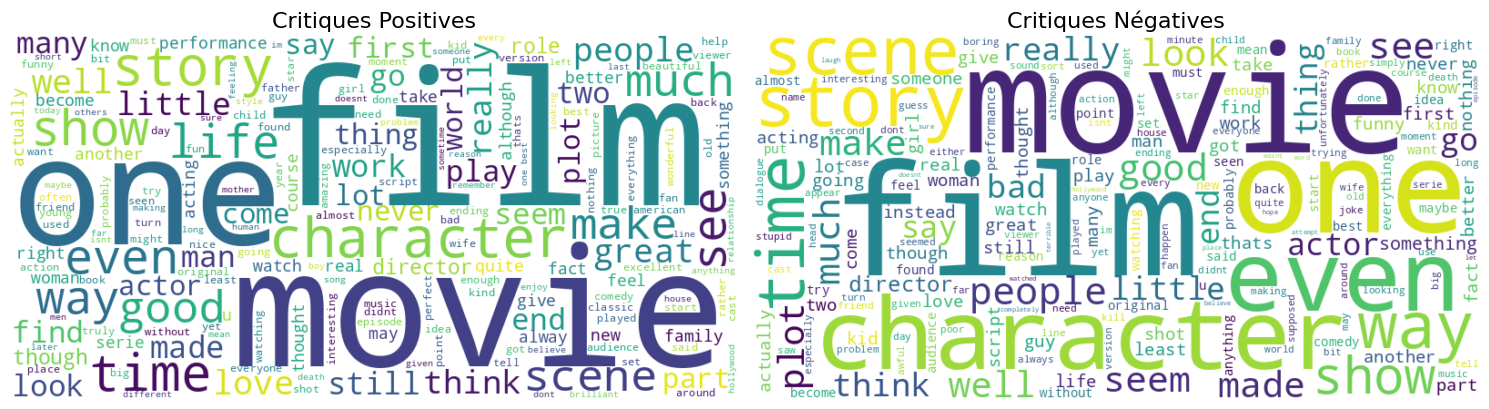

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 ligne, 2 colonnes

# Critiques positives
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title("Critiques Positives", fontsize=16)
axes[0].axis("off")  # Supprimer les axes

# Critiques négatives
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title("Critiques Négatives", fontsize=16)
axes[1].axis("off")  # Supprimer les axes

# Ajuster les espacements
plt.tight_layout()
plt.show()

Il est difficile de discerner les mots positif de négatif, on observe notament good apparaitre pour les deux labels: c'est pourquoi le contexte semble interessant dans cette tache.

## Tokenization

Il est nécessaire de passer par une phase de tokenization avant de traiter le texte pour la classification sentimentale. C'est un processus de division d’un texte en unités nommées tokens.

Les modèles que nous allons utiliser travaillent avec des données numériques, mais les critiques sont sous forme de texte brut. La tokenization permet de convertir le texte en un format exploitable par les modèles.
Lors de la tokenization, les mots sont associés à des indices dans un vocabulaire, permettant au modèle de manipuler les séquences de manière efficace.

Pour notre tâche de sentiment analysis, une représentation séquentielle est plus adaptée pour plusieurs raisons:

* Les RNN, LSTM et GRU traitent les données de façon séquentielle, en tenant compte de l'ordre des mots. Cela permet au modèle de comprendre des structures syntaxiques importantes et pertinentes.

* Le dataset IMDb contient des critiques où l'ordre des mots et les relations entre les mots sont importants pour analyser le sentiment exprimé. Une représentation séquentielle permet de capturer ces nuances.

Nous avons donc décidé d'utiliser une tokenization par séquence. La tokenization basée sur les séquences est une méthode qui convertit un texte en une liste ordonnée d'indices numériques, chaque entier représentant un mots du texte. Cette approche conserve l'ordre des mots, ce qui est essentiel pour capturer les relations syntaxiques et sémantiques entre eux.

Dans le cadre du sentiment analysis, on construit un vocabulaire créé à partir du corpus d’entraînement, où chaque mot unique est associé à un indice numérique. Les mots les plus fréquents sont priorisés. Chaque mot d’une phrase est remplacé par son indice correspondant dans le vocabulaire.

Les mots absents du vocabulaire (parce qu’ils sont rares ou hors du corpus d’entraînement) sont remplacés par un token spécial : *OOV* (Out-Of-Vocabulary).

Comme nous l'avions signalé plus haut, les critiques sont de longueurs variées. Or, les modèles ne peuvent prendre que des entrées de même longueurs.  Nous allons donc tronquer ou remplir (via un padding) les séquences.

Afin d'orienter nos choix nous affichons les informations suivantes:

Longueur moyenne des critiques d'entraînement (nettoyées) : 121.24 mots
Longueur moyenne des critiques de test (nettoyées) : 118.46 mots
Proportion des critiques d'entraînement plus longues que 200 mots (nettoyées) : 14.57%
Proportion des critiques de test plus longues que 200 mots (nettoyées) : 13.55%


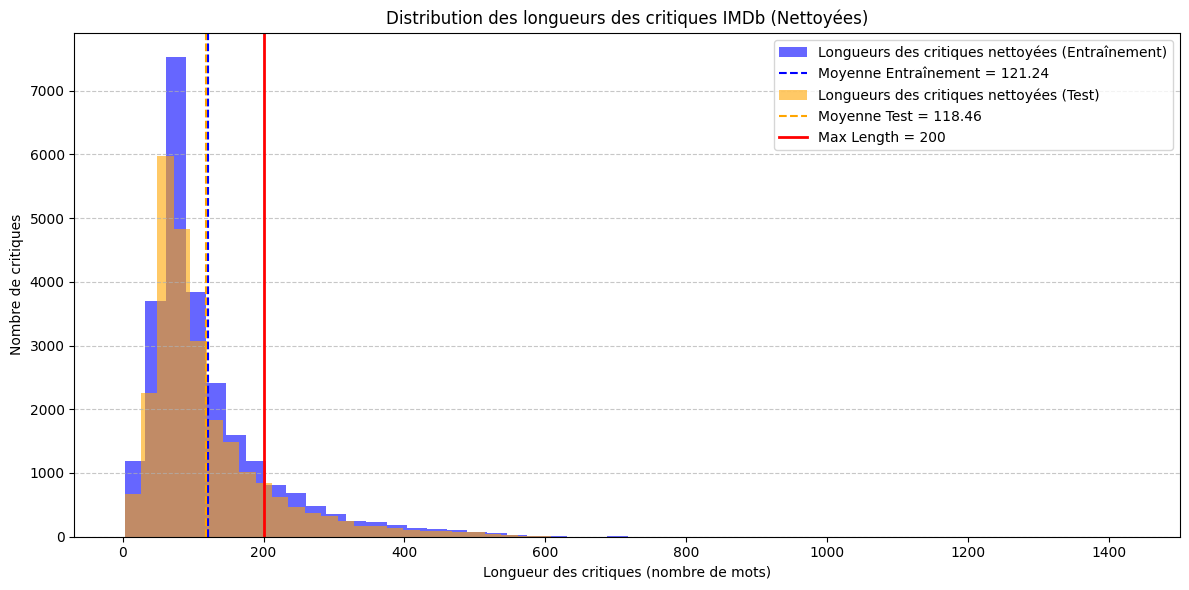

In [17]:
# Calculer la longueur de chaque critique nettoyée pour les datasets
train_lengths_cleaned = train_df['text'].apply(lambda x: len(x.split()))
test_lengths_cleaned = test_df['text'].apply(lambda x: len(x.split()))

# Calculer la longueur moyenne des critiques nettoyées
average_train_length_cleaned = train_lengths_cleaned.mean()
average_test_length_cleaned = test_lengths_cleaned.mean()

# Afficher les résultats
print(f"Longueur moyenne des critiques d'entraînement (nettoyées) : {average_train_length_cleaned:.2f} mots")
print(f"Longueur moyenne des critiques de test (nettoyées) : {average_test_length_cleaned:.2f} mots")

# Vérifier la proportion des critiques plus longues que max_length
max_length = 200  # Longueur maximale définie
train_above_max_cleaned = (train_lengths_cleaned > max_length).mean() * 100
test_above_max_cleaned = (test_lengths_cleaned > max_length).mean() * 100

print(f"Proportion des critiques d'entraînement plus longues que {max_length} mots (nettoyées) : {train_above_max_cleaned:.2f}%")
print(f"Proportion des critiques de test plus longues que {max_length} mots (nettoyées) : {test_above_max_cleaned:.2f}%")

# Visualisation de la distribution des longueurs nettoyées
plt.figure(figsize=(12, 6))

# Histogramme pour les données d'entraînement nettoyées
plt.hist(train_lengths_cleaned, bins=50, alpha=0.6, color='blue', label='Longueurs des critiques nettoyées (Entraînement)')
plt.axvline(average_train_length_cleaned, color='blue', linestyle='dashed', linewidth=1.5, label=f'Moyenne Entraînement = {average_train_length_cleaned:.2f}')

# Histogramme pour les données de test nettoyées
plt.hist(test_lengths_cleaned, bins=50, alpha=0.6, color='orange', label='Longueurs des critiques nettoyées (Test)')
plt.axvline(average_test_length_cleaned, color='orange', linestyle='dashed', linewidth=1.5, label=f'Moyenne Test = {average_test_length_cleaned:.2f}')

# Ligne verticale pour la longueur maximale
plt.axvline(max_length, color='red', linestyle='solid', linewidth=2, label=f'Max Length = {max_length}')

# Configuration du graphique
plt.title("Distribution des longueurs des critiques IMDb (Nettoyées)")
plt.xlabel("Longueur des critiques (nombre de mots)")
plt.ylabel("Nombre de critiques")
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()


In [18]:
# Ajouter une colonne 'token_length' avec la longueur de chaque critique
train_df['token_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Filtrer les critiques positives et afficher les statistiques
data_pos = train_df[train_df['label'] == 1]
print("Statistiques descriptives pour les critiques positives :")
display(data_pos['token_length'].describe())

# Filtrer les critiques négatives et afficher les statistiques
data_neg = train_df[train_df['label'] == 0]
print("Statistiques descriptives pour les critiques négatives :")
display(data_neg['token_length'].describe())

Statistiques descriptives pour les critiques positives :


,token_length
count,12500.000000
mean,123.244080
std,95.300154
min,7.000000
25%,64.000000
50%,90.000000
75%,152.000000
max,1429.000000


Statistiques descriptives pour les critiques négatives :


,token_length
count,12500.000000
mean,119.243200
std,87.017314
min,4.000000
25%,65.000000
50%,90.000000
75%,144.000000
max,810.000000


On remarque que la longueur moyenne est de 121 mots.
De plus, on remarque que la longueur des commentaires n'a pas d'influence notable sur la classe du commentaire, on peut donc effectuer le padding sans problème.

On choisit une longueur d'entrée de 200. Il s'agit d'une valeur arbitraire souvent choisie dans la litérature et cohérente avec notre dataset. on voit que la très grande majorité des mots (<80%) est inférieur à 200 mots.

Enfin, nous avons un total de 210 000 mots uniques dans le dataset. Réduire à un vocabulaire de 10 000 mots avec notre tokenization capture les mots les plus fréquents, ce qui est souvent suffisant dans l'état de l'art de la classification de sentiment.

Ce seuil de 5% à 10% du vocabulaire total est communément utilisé dans les tâches NLP. Ce seuil est un compromis entre : conserver suffisamment de vocabulaire pour capturer le sens du texte, et limiter les ressources nécessaires pour entraîner le modèle.

Notre tâche étant plutot facile à priori (pas de détection de style, classification multiclasse,...)

In [19]:
# Initialisation du tokenizer
vocab_size = 10000  # Taille du vocabulaire
max_length = 200  # Longueur maximale des séquences
oov_token = "<OOV>"  # Token pour les mots hors vocabulaire

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(merged_df['text'])  # tokenization sur l'ensemble des données


# Conversion des textes en séquences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])


# Padding des séquences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Conversion des labels
train_labels = np.array(train_df['label'].values)
test_labels = np.array(test_df["label"].values)

# Affichage des résultats
print(f"Exemple de séquence tokenisée : {train_sequences[0][:10]}")
print(f"Exemple de séquence avec padding : {train_padded[0]}")
print(f"Taille du vocabulaire : {len(tokenizer.word_index)}")


Exemple de séquence tokenisée : [527, 32, 1547, 2702, 1, 562, 9456, 3, 356, 94]
Exemple de séquence avec padding : [ 527   32 1547 2702    1  562 9456    3  356   94 2712    6    1  386
  169    4 1343    3  134   35 1290 3862  420  633 1390  449  832 3863
  681  527  527  165  356   11 2763 9937 1290 1495  607    1   11  142
 1290 5480  216 2785    1 6989 1137 5421  173  169   70  277  891    3
  321  250  685  111  101  819  347  414  189 3585    3 5045  481   94
  639  418 5421  367  440 1044   88    1  824    3   59   83  169   34
  354  132  280  809 7545 4122   16  440   16 1283   46 1350 2743  542
 3175  569    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   

#### Test de reconstruction

In [20]:
# Nettoyer une critique d'origine
cleaned_text = merged_df['text'].iloc[0]

# Conversion en séquence tokenisée
tokenized_sequence = tokenizer.texts_to_sequences([cleaned_text])[0]

# Reconstruire le texte à partir de la séquence
reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

# Afficher les résultats
print("Texte original (nettoyé) :")
print(cleaned_text[:300])  # Limiter à 300 caractères pour éviter les sorties trop longues

print("\nSéquence tokenisée :")
print(tokenized_sequence[:20])  # Limiter à 20 tokens pour simplifier la lecture

print("\nTexte reconstruit :")
print(reconstructed_text[:300])  # Limiter à 300 caractères

Texte original (nettoyé) :
dog go heaven par watership scary kiddy film dark pretty sinister time mesmerising experience child one favourite film kid love charlie tender age five six ill admit crush cartoon dog dog tell dark story lovable cad charlie partner crime itchy story start charlie escaping death row swaggering neares

Séquence tokenisée :
[527, 32, 1547, 2702, 1, 562, 9456, 3, 356, 94, 2712, 6, 1, 386, 169, 4, 1343, 3, 134, 35]

Texte reconstruit :
dog go heaven par <OOV> scary kiddy film dark pretty sinister time <OOV> experience child one favourite film kid love charlie tender age five six ill admit crush cartoon dog dog tell dark story lovable cad charlie partner crime <OOV> story start charlie escaping death row <OOV> nearest club gambling


Dans cet exemple, la tokenization a été effectuée correctement, bien que certains mots aient été remplacés par OOV, indiquant qu'ils n'appartiennent pas au vocabulaire construit.

On signalera enfin que le début de cette critique, ou du moins les 200 premiers mots, suffisent à comprendre le sentiment exprimé.

Toutes ces observations confirment bien nos choix précédents.

In [21]:
# Calculer le pourcentage de mots hors vocabulaire
oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
total_count = len(tokenized_sequence)
oov_percentage = (oov_count / total_count) * 100

print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")


Proportion des mots hors vocabulaire : 5.00%


Les séquences sont correctement transformées et prêtes pour être utilisées dans un modèle. La taille du vocabulaire est raisonnable pour inclure les mots les plus informatifs tout en excluant les mots rares ou inutiles.

# Créations des modèles

Dans cette partie nous allons créer 5 modèles différents et essayer des les optimiser pour notre tâche de sentiment analysis. Nous lancerons un entrainement sur chaque afin d'avoir une première idée des performances et de pouvoir comparer différentes architecture d'un modèle avant l'optimisation des hyperparamêtres dans la partie suivante.

## Preparation des données

In [22]:
# Séparation des données
train_padded_train, train_padded_val, train_labels_train, train_labels_val = train_test_split(
    train_padded, train_labels, test_size=0.2, random_state=42
)

# Reconversion des labels en tenseurs TensorFlow
train_labels_train = tf.convert_to_tensor(train_labels_train, dtype=tf.int32)
train_labels_val = tf.convert_to_tensor(train_labels_val, dtype=tf.int32)

# Vérification des formes
print(f"Entraînement : {train_padded_train.shape}, Labels : {train_labels_train.shape}")
print(f"Validation : {train_padded_val.shape}, Labels : {train_labels_val.shape}")


Entraînement : (20000, 200), Labels : (20000,)
Validation : (5000, 200), Labels : (5000,)


### Affichage des performances


In [23]:
def plot_history(hist, tps):

  print(f'Training time: {tps:.0f}')

  # Récupération des métriques d'entraînement et validation
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # Plot de la courbe d'accuracy
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot de la courbe de loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


  # Affichage des valeurs finales
  print(f"Final Training Accuracy: {acc[-1]:.4f}")
  print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
  print(f"Final Training Loss: {loss[-1]:.4f}")
  print(f"Final Validation Loss: {val_loss[-1]:.4f}")

## Hyperparametres

On choisit les hypers paramêtres suivant pour les réseaux:
- dim hiddenlayer1: 512
- dim hiddenlayer2 : 256
- dim dense layer : 256
- dropout : 0.2
- learning rate: 0.01
- dim embedding: 200


Ces paramêtres ont été choisie de manières arbitraire après le teste de plusieurs possibilité. Ils permettent d'obtenir déjà de bon résultats, et sont commun dans ce genre de problemes.

Nous choisisson d'utiliser une fonctoin reLU pour les couches denses car elle permet un calcul rapide et évite le probleme de vanishing gradient que l'on peut rencontrer avec tanh par exemple.

In [24]:
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 200  # Taille des vecteurs de mots
dim_h1 = 512
dim_h2 = 256
dim_dl = 256
max_length = 200  # Longueur maximale des séquences
drop_rate = 0.2  # Taux de dropout
lr = 0.001

## RNN

Notre tâche est une tâche de sentiment analysis, donc du *Many-To-One*. En d'autres termes, seul l'état caché du dernier pas temporel est récupéré pour la sortie finale.

### RNN à une couche cachée:

Architecture:

- **Couche d'Embedding :**
  - Transforme chaque mot en un vecteur dense (embedding).
  - Capture les relations sémantiques et syntaxiques entre les mots.
  - Les embeddings sont appris pendant l'entraînement du modèle.
  - **Dimension d'embedding :** 200 c'est la taille maximales, 85% des commentaires seront biens représentés

- **Couche RNN :**
  - Une seule couche RNN
  - **`return_sequences=False`** : Renvoie uniquement l'état caché final, adapté à une tâche *Many-To-One*.
  - La simplicité de la couche permet d'analyser si les dépendances séquentielles sont simples ou nécessitent un réseau plus complexe.

- **Couche Dropout :**
  - **Taux de Dropout : 20 %**, abandonnant aléatoirement des neurones pour prévenir le surapprentissage.

- **Couche Dense en sortie :**
  - Une seule unité (neurone) avec une activation **sigmoid**, adaptée à la classification binaire.

- **Fonction de perte (Loss) :**
  - **Binary Cross Entropy**, idéale pour la classification binaire.

- **Paramètres d'entraînement :**
  - **Taille de batch :** 64, optimisée pour l'utilisation du GPU.
  - **Nombre d'époques :** 10, une valeur classique pour observer une convergence.

- **Optimiseur :**
  - **Adam** avec un learning rate de **0.001** (valeur standard), choisi pour :
    - Sa vitesse de convergence.
    - Sa robustesse.
    - Sa capacité à ajuster automatiquement les pas d'apprentissage.


In [ ]:
# Définition du modèle RNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(dim_h1, return_sequences=False),
    Dropout(drop_rate),
    Dense(dim_dl, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')
])


# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

start = time.time()
# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)

end = time.time()

tps = end - start

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.4988 - loss: 0.7743 - val_accuracy: 0.5024 - val_loss: 0.7923
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5041 - loss: 0.7185 - val_accuracy: 0.4980 - val_loss: 0.7010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4942 - loss: 0.7059 - val_accuracy: 0.4970 - val_loss: 0.7171
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.4963 - loss: 0.7037 - val_accuracy: 0.5030 - val_loss: 0.6979
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5007 - loss: 0.7012 - val_accuracy: 0.4986 - val_loss: 0.6963
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.4977 - loss: 0.6977 - val_accuracy: 0.5030 - val_loss: 0.7013
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5007 - loss: 0.6987 - val_accuracy: 0.5010 - val_loss: 0.6948
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.5051 - loss: 0.6957 - 

Training time: 102


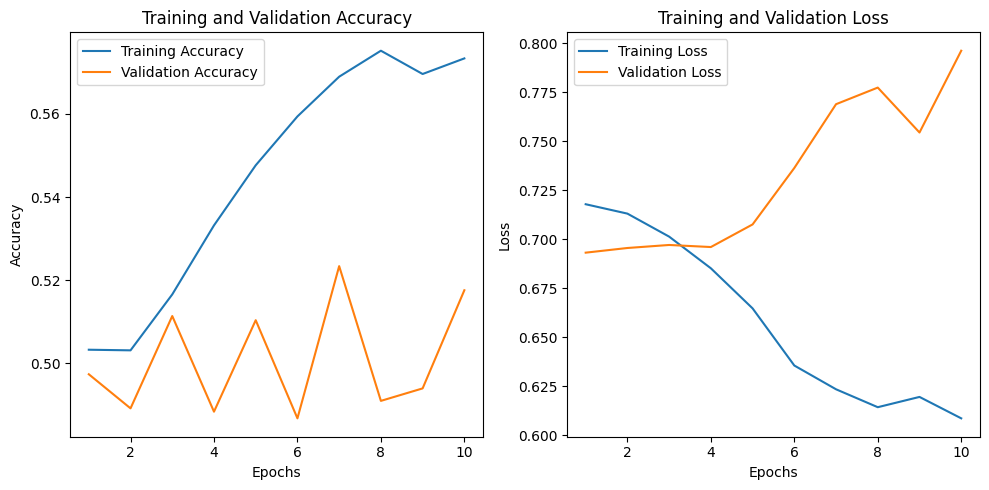

Final Training Accuracy: 0.5734
Final Validation Accuracy: 0.5176
Final Training Loss: 0.6087
Final Validation Loss: 0.7963


In [ ]:
plot_history(history, tps)

Le temps de calcul est de 102s

---

Le modèles est incapble de prédire un sentiment, stagnant autour de 0.5.


### RNN à deux couches cachées

On tente d'améliorer le modèle en ajoutant un seoncd RNN en sortie du premier.
Cette couche permet au modèle d'apprendre des représentations plus abstraites après la première couche, et donc d'affiner les représentations. Cela améliore la capacité du modèle à capturer des représentations riches.
De plus, gagner en profondeur de modèle peut aider à mieux modéliser les données d'entrée. On peut donc esperer de meilleures performances avec ce changement.

On ajoute également une couche de dropout afin de prévenir le resique de surapprentissage.

On note que la premiere couche RNN a return sequence à true, en effet, elle fait du many2many.

In [ ]:
# Définition du modèle avec une couche SimpleRNN supplémentaire
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(dim_h1, return_sequences=True),  # Première couche RNN
    SimpleRNN(dim_h2, return_sequences=False),  # Deuxième couche RNN
    Dropout(drop_rate),  # Dropout après la deuxième couche
    Dense(dim_dl, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()
start = time.time()
# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)
end = time.time()
tps = end - start

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (1, 200, 256)               │          91,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 200, 256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (1, 128)                    │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,801 (4.35 MB)

 Trainable params: 1,140,801 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.4906 - loss: 0.7591 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.4987 - loss: 0.7280 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.5010 - loss: 0.7140 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5012 - loss: 0.7059 - val_accuracy: 0.5030 - val_loss: 0.6944
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.5014 - loss: 0.7027 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5007 - loss: 0.7003 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.4967 - loss: 0.6995 - val_accuracy: 0.4970 - val_loss: 0.6950
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5034 - loss: 0.6961 - 

Training time: 234


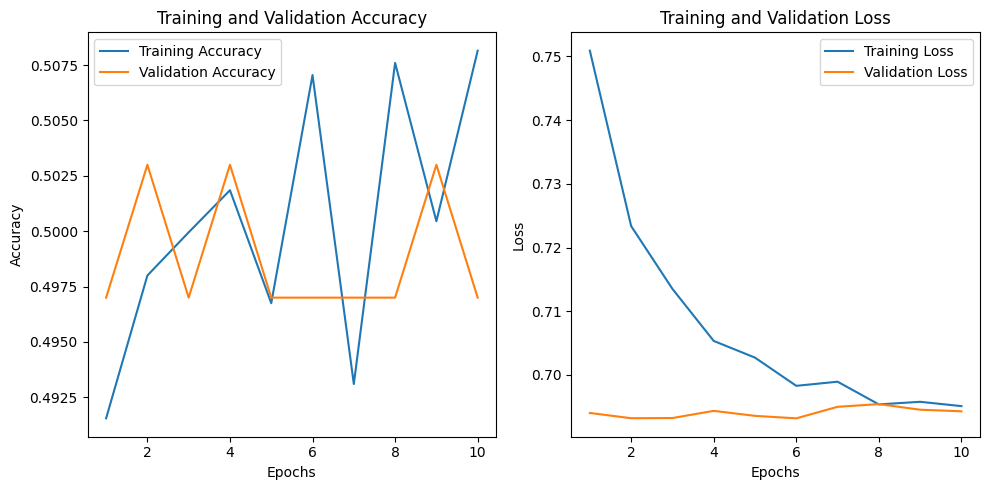

Final Training Accuracy: 0.5081
Final Validation Accuracy: 0.4970
Final Training Loss: 0.6951
Final Validation Loss: 0.6943


In [ ]:
plot_history(history, tps)

Le temps de calcul est de 234s.

---

L'augmentation de la pronfondeur ne résout pas nos problèmes, nous obtenons les mémes résultats. Ce problème peut être dû aux deux problèmes principaux des RNN:
* Vanashing/exploding gradient
* Difficulté à retenir les dépendances longues

---

Ainsi, le temps de calcul est doublé par rapport au modèle précédent, et il n'y a aucune amélioration des perfomrances, on utiliseras donc une seule couche cachée pour l'optimisation des paramêtres.





Afin, d'éviter le *Vanishing Gradient* et capturer des relations à long terme dans les séquences, d'autres arhitectures adaptées existent, comme les LSTM et les GRU, que nous allons abordé dans la partie suivante.

## LSTM


### LSTM à une couche cachée


Comme indiqué et observé dans la partie précédente, les RNN souffrent du problème de *Vanishing Gradient* lors de l'entrainement sur des séquences longues à travers le BPTT.

Les Long Short-Term Memory, ou **LSTM**, sont une variante des RNN permettant une meilleure gestion de la mémoire à long terme, conçu pour résoudre le problème de *Vanishing Gradient* et permettre de capturer des dépendance à plus long termes

---
Résumé de l'architecture LSTM


- **Couche d'embeddings :**
  - Embeddings entraînables pour représenter les mots dans un espace dense, similaire à ce qui a été fait pour le RNN.

- **Couche LSTM :**
  - Capture les dépendances temporelles des séquences.
  - **128 unités** pour un compromis entre profondeur et complexité.
  - **`return_sequences=False`** : Renvoie uniquement l'état caché final, adapté à un cas *Many-To-One*.

- **Couche Dropout :**
  - Placée entre la couche LSTM et la couche dense pour régulariser et prévenir le surapprentissage.

- **Couche Dense :**
  - Permet de traiter les données brute en sortie du LSTM

- **Couche Dense de sortie :**
  - Une seule unité avec une activation **sigmoid**, adaptée à la classification binaire.

- **Fonction de perte et optimiseur :**
  - **Perte :** Cross-Entropy binaire, idéale pour la classification binaire.
  - **Optimiseur :** Adam par défaut, choisi pour sa robustesse et sa rapidité de convergence.


In [ ]:
# Construction du modèle
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(dim_h1, return_sequences=False),  # Une seule couche LSTM
    Dropout(drop_rate),  # Régularisation pour éviter l'overfitting
    Dense(dim_dl, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])


# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
# Compilation avec un learning rate encore plus bas
model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start

ModuleNotFoundError: No module named 'optuna'

Training time: 201


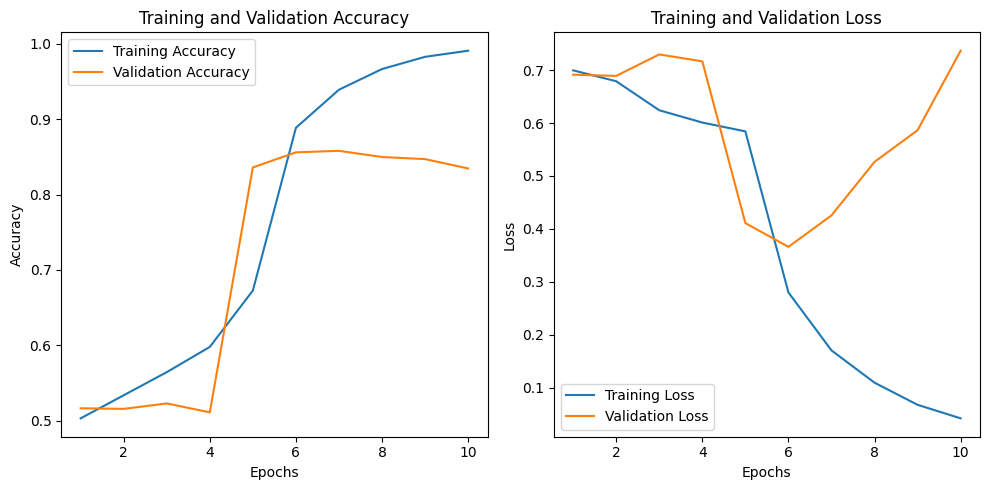

Final Training Accuracy: 0.9908
Final Validation Accuracy: 0.8346
Final Training Loss: 0.0421
Final Validation Loss: 0.7366


In [ ]:
plot_history(history, tps)

Le temps de calcul est 200s , bien supérieur au temps de calcul d'un RNN

---


Les résultats montrent une amélioration claire avec l'utilisation des LSTM par rapport aux SimpleRNN. Nous passons de 50% à 83% de précision sur les données de validation. Le modèle parvient maintenant à apprendre les relations pertinentes dans les données d'apprentissage (l'ajout d'une couche de dropout n'a rien changé)

On observe tout de même un sur apprentissage important.


En somme, notre LSTM résout bien le problème de *Vanishing Gradient*.

### LSTM à 2 couches cachées

Afin d'améliorer les performances de notre modèles nous ajoutons 2 couches de LSTM à la suite dans notre modèle.

**Réduction de la dimension dans la deuxième couche**:
Les couches LSTM consécutives apprennent des représentations hiérarchiques. La première couche capture des dépendances temporelles "brutes", tandis que la deuxième couche affine ces informations. La deuxieme couche va donc permettre de simplifier la représentation des informations et de la condenser.

In [ ]:
# Modèle avec deux couches LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(dim_h1, return_sequences=True),  # Première couche LSTM
    LSTM(dim_h2, return_sequences=False),  # Seconde couche LSTM
    Dropout(drop_rate),
    Dense(dim_dl, activation='relu'),  # Couche Dense
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.5079 - loss: 0.6942 - val_accuracy: 0.5088 - val_loss: 0.6929
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.5339 - loss: 0.6831 - val_accuracy: 0.5134 - val_loss: 0.6979
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.5603 - loss: 0.6391 - val_accuracy: 0.6398 - val_loss: 0.6467
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.5763 - loss: 0.6740 - val_accuracy: 0.5318 - val_loss: 0.6878
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.6019 - loss: 0.6666 - val_accuracy: 0.6304 - val_loss: 0.6375
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.6846 - loss: 0.6018 - val_accuracy: 0.6946 - val_loss: 0.6349
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.7841 - loss: 0.4627 - val_accuracy: 0.8390 - val_loss: 0.4043
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8838 - loss: 0.2957 - 

Training time: 371


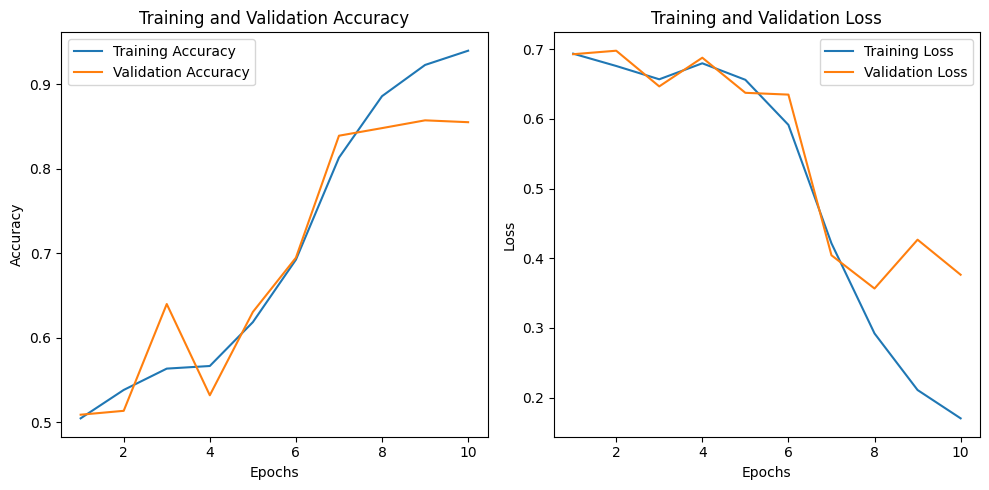

Final Training Accuracy: 0.9396
Final Validation Accuracy: 0.8550
Final Training Loss: 0.1702
Final Validation Loss: 0.3763


In [ ]:
plot_history(history, tps)

Le temps de calcul est de 371s, le double d'un LSTM à une couche

---

Les performances sont améliorées, passant de 83% à 85%, de plus le surapprentissage a été diminué.

---

On décide de conserver le modèles précédent, en effet, le gain est trop peu pertinent par rapport à l'augmentation de temps de calcul.

Nous sommes satisfait des résultats de cette architecture et nous n'explorerons pas d'avantage (augmentation du nombre de couche, drop out, couche dense,...), qui risquerait d'aumgenter encore d'avantage le temps de calcul pour une amélioration minime.

## GRU

### GRU à une couche cachée

Tout comme les LSTM, les **Gated Recurrent Unit** sont une variante des RNN permettant une meilleure gestion de la mémoire à long terme, conçu pour résoudre le problème de *Vanishing Gradient*. Utilsant seulement 2 portes (au lieu des 3 du LSTM), les **GRU** sont généralement plus rapides à entrainer et moins gourmands en ressources, mais en compensation sont moins performant pour capturer les dépendances longues.

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(dim_h1, return_sequences=False),
    Dropout(drop_rate),  # Régularisation pour éviter l'overfitting
    Dense(dim_dl, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5085 - loss: 0.6944 - val_accuracy: 0.4966 - val_loss: 0.6939
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.5130 - loss: 0.6933 - val_accuracy: 0.5074 - val_loss: 0.7045
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6636 - loss: 0.5805 - val_accuracy: 0.8454 - val_loss: 0.3724
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9202 - loss: 0.2171 - val_accuracy: 0.8688 - val_loss: 0.3693
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9655 - loss: 0.1057 - val_accuracy: 0.8498 - val_loss: 0.4372
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9853 - loss: 0.0500 - val_accuracy: 0.8392 - val_loss: 0.5999
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9922 - loss: 0.0281 - val_accuracy: 0.8188 - val_loss: 0.7357
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9947 - loss: 0.0167 - 

Training time: 175


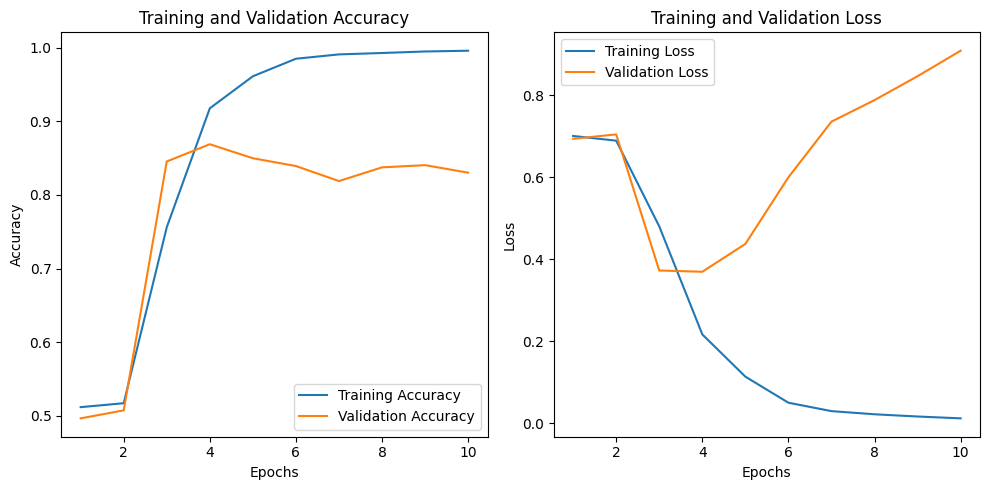

Final Training Accuracy: 0.9958
Final Validation Accuracy: 0.8302
Final Training Loss: 0.0115
Final Validation Loss: 0.9088


In [ ]:
plot_history(history, tps)

Le temps de calcule est de 175. Le temps est meilleur de 12% par rapport à un LSTM équivalent

---

Notre modèle GRU obtient des résultats proches de ceux du LSTM, atteignant 83% en validation. On observe le même phénomène de surapprentissage que le modèle LSTM.

### GRU à deux couches cachée

Le comportement obtenu étant très proche de celui obtenu pour le LSTM, nous décidont d'augmenter également à deux douches le modèle GRU.

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(dim_h1, return_sequences=True),
    GRU(dim_h2, return_sequences=False),
    Dropout(drop_rate),  # Régularisation pour éviter l'overfitting
    Dense(dim_dl, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.5064 - loss: 0.6943 - val_accuracy: 0.4970 - val_loss: 0.6941
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5202 - loss: 0.6877 - val_accuracy: 0.5094 - val_loss: 0.6900
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.5595 - loss: 0.6480 - val_accuracy: 0.7430 - val_loss: 0.5410
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.8465 - loss: 0.3580 - val_accuracy: 0.8558 - val_loss: 0.3437
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9342 - loss: 0.1794 - val_accuracy: 0.8492 - val_loss: 0.3980
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.9680 - loss: 0.1005 - val_accuracy: 0.8618 - val_loss: 0.4284
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accuracy: 0.8542 - val_loss: 0.5131
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9889 - loss: 0.0384 - 

Training time: 300


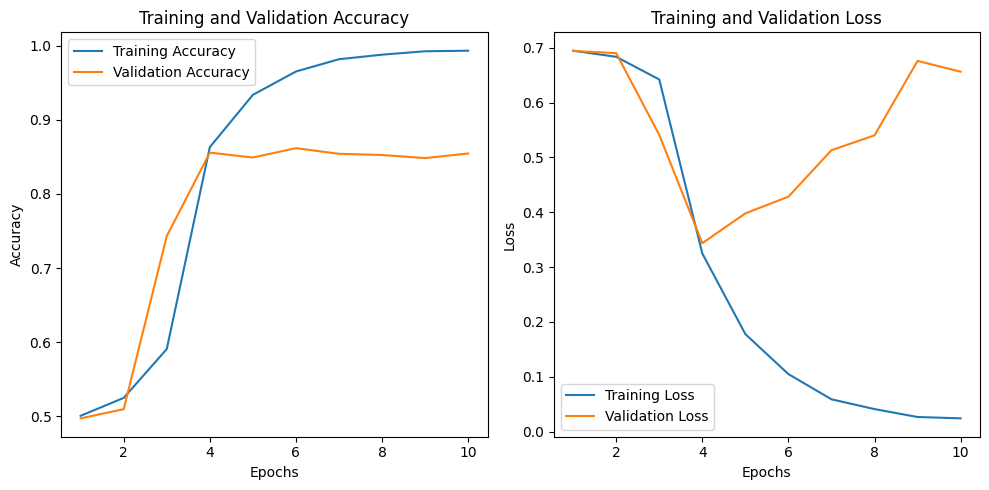

Final Training Accuracy: 0.9934
Final Validation Accuracy: 0.8546
Final Training Loss: 0.0244
Final Validation Loss: 0.6562


In [ ]:
plot_history(history, tps)

Le temps de calcul est de 395s A nouveau il a doublé par rapport au GRU à une couche

---

On remarque que la performance augmente de 2%, et que le sruapprentissage est toujours présent.

Tout comme le LSTM, nous nous arretons là pour la recherche d'amélioration des performances. Nous décidons de choisir le modèles précédent qui a sensiblement les même perforamnces, et qui est 2 fois plus rapide.

## MLP

l'utilisation d'un MLP signifie qu'il n'y a plus de sequentiallisation des données, on perds donc cette information. On s'attends totuefois à avoir un plus grande rapidité de calcul.

### MLP à deux couches cachées

- **Générique :**
  - Adaptée à diverses tâches de classification binaire.
  - Optimisée pour travailler avec des embeddings.

- **Composants principaux :**
  - **Embedding :** Transforme les mots en vecteurs denses.
  - **Flatten :** Convertit les sorties multidimensionnelles en une seule dimension pour le MLP.
  - **Deux couches denses cachées :**
    - Activation **ReLU** pour capturer des relations non linéaires.
    - **Dropout** pour éviter le sur-apprentissage.
  - **Sigmoid :** Activation pour produire une probabilité binaire en sortie.

In [ ]:
# Construction du modèle MLP
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),  # Couche d'embedding
    Flatten(),  # Average the word embeddings
    Dense(dim_h1, activation='relu'),  # Première couche dense
    Dense(dim_h2, activation='relu'),  # Deuxième couche dense
    Dropout(drop_rate),  # Dropout après la deuxième couche dense

    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5977 - loss: 0.6392 - val_accuracy: 0.8460 - val_loss: 0.3607
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8644 - loss: 0.3174 - val_accuracy: 0.8516 - val_loss: 0.3488
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9152 - loss: 0.2172 - val_accuracy: 0.8286 - val_loss: 0.4242
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9171 - loss: 0.2134 - val_accuracy: 0.8764 - val_loss: 0.3342
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9337 - loss: 0.1715 - val_accuracy: 0.7938 - val_loss: 0.5521
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9389 - loss: 0.1540 - val_accuracy: 0.8300 - val_loss: 0.4921
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9373 - loss: 0.1546 - val_accuracy: 0.8730 - val_loss: 0.3697
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9589 - loss: 0.1156 - val_accuracy: 0

Training time: 18


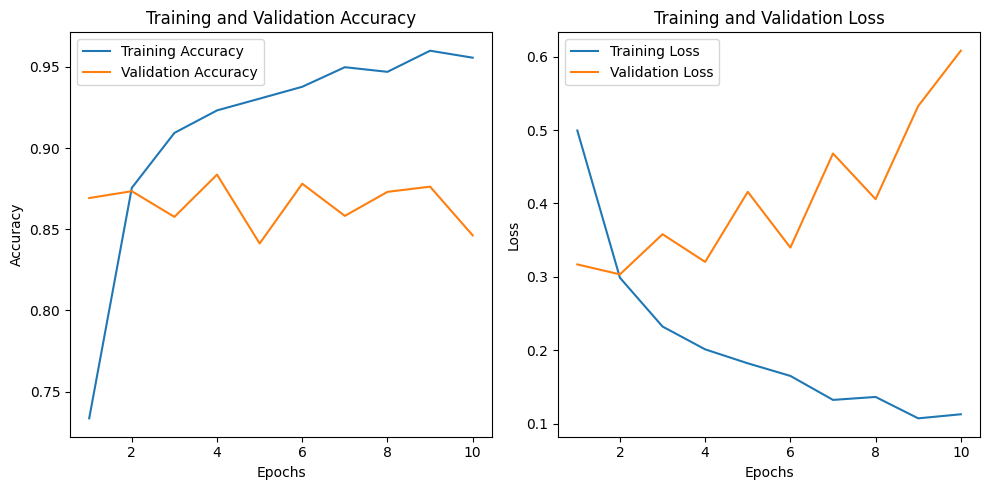

Final Training Accuracy: 0.9556
Final Validation Accuracy: 0.8462
Final Training Loss: 0.1127
Final Validation Loss: 0.6081


In [ ]:
plot_history(history, tps)

Le temps de calcul est 18s. Il est extremement cours

---

Les performances sont bonnes, 84% de précision sur les données de valdiation, mais on observe un surapprentissage important. L'utilisation nécessaire de global max pooling détruit partiellement les la projection de l'embedding séquentielle ce qui peut expliquer ce comportement. Il se peut également que la convegence soit atteint très vite (0 à 1 epoch), et que le modèle ne soit pas capable de capturer plus d'informations.

### MLP à 4 couches cachées

On décide de doubler chaque couche afin de voir le comportement du modèle.

In [ ]:
# Construction du modèle MLP
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),  # Average the word embeddings

    Dense(dim_h1, activation='relu'),
    Dropout(drop_rate),

    Dense(dim_h1, activation='relu'),
    Dropout(drop_rate),

    Dense(dim_h2, activation='relu'),
    Dropout(drop_rate),

    Dense(dim_h2, activation='relu'),
    Dropout(drop_rate),

    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])


# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'GlobalAveragePooling1D' is not defined

Training time: 17


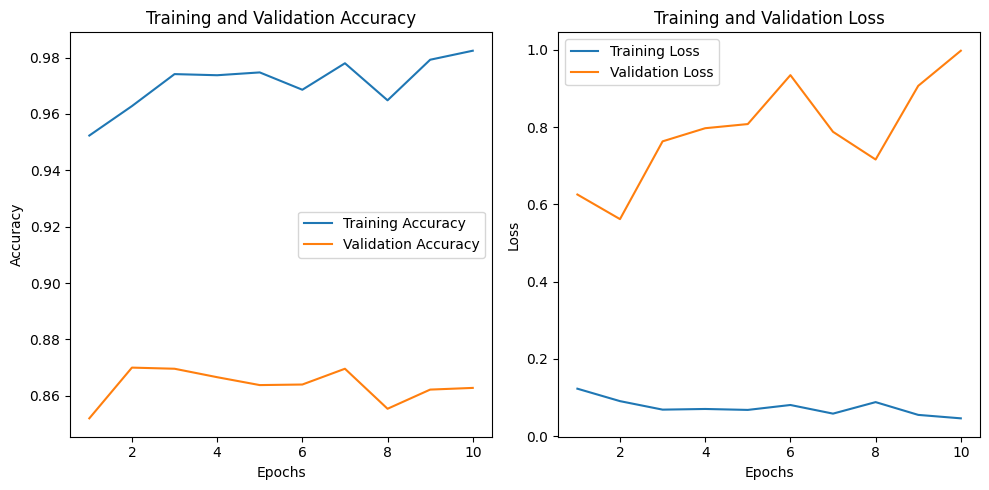

Final Training Accuracy: 0.9825
Final Validation Accuracy: 0.8628
Final Training Loss: 0.0462
Final Validation Loss: 0.9975


In [ ]:
plot_history(history, tps)

Le temps est de 17s. Il n'y a pas de modification du temps avec l'ajout de couche denses.

---

Le comportement relevé précédement est toujours présent. On obtient toutefois un amélioration avec une précision de 85% en validation. Il se peut que le modèle sne puissent apprendre plus de 85% sans utiliser de contexte séquentiel.

## CNN 1D

### CNN à deux convolutions

#### **1. Embeddings :**
- Transforment les mots en représentations vectorielles denses.

#### **2. Convolution 1D (Conv1D) :**
- Capture des motifs locaux (n-grams) dans les textes.
- Extrait des caractéristiques importantes tout en réduisant la dépendance à l’ordre complet des mots.

#### **4. Couches denses finales :**
- Une couche Dense affine les caractéristiques extraites (ex. : 128 neurones).
- **Dropout** prévient l’overfitting.
- Une activation **sigmoid** en sortie est utilisée pour les tâches de classification binaire.


In [26]:
# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Embedding de taille 200
    Conv1D(filters=dim_h1, kernel_size=3, activation='relu'),  # Première couche Conv1D
    Conv1D(filters=dim_h2, kernel_size=5, activation='relu'),  # Deuxième couche Conv1D
    GlobalMaxPooling1D(),  # Réduction des dimensions avec GlobalMaxPooling1D
    Dropout(drop_rate),  # Dropout pour la régularisation
    Dense(dim_dl, activation='relu'),  # Couche Dense
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])



# Compilation du modèle
optimizer = Adam(learning_rate=lr)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=32,  # Taille du batch optimisée
)

# Affichage du modèle
model_cnn.summary()
end = time.time()
tps = end - start



Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6868 - loss: 0.5464 - val_accuracy: 0.8358 - val_loss: 0.3654
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9072 - loss: 0.2341 - val_accuracy: 0.8472 - val_loss: 0.3864
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9617 - loss: 0.1035 - val_accuracy: 0.8554 - val_loss: 0.4347
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9852 - loss: 0.0437 - val_accuracy: 0.8558 - val_loss: 0.5530
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9900 - loss: 0.0305 - val_accuracy: 0.8570 - val_loss: 0.6773
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9931 - loss: 0.0225 - val_accuracy: 0.8452 - val_loss: 0.6815
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9934 - loss: 0.0192 - val_accuracy: 0.8480 - val_loss: 0.7418
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9943 - loss: 0.0148 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 200, 200)              │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (32, 198, 512)              │         307,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (32, 194, 256)              │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (32, 256)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 256)                   │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,088,133 (34.67 MB)

 Trainable params: 3,029,377 (11.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,058,756 (23.11 MB)

Training time: 115


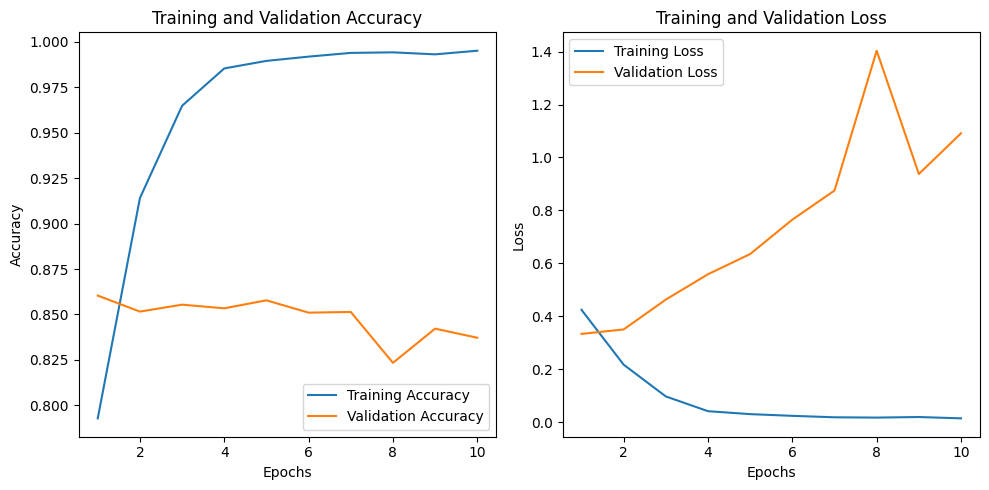

Final Training Accuracy: 0.9952
Final Validation Accuracy: 0.8372
Final Training Loss: 0.0146
Final Validation Loss: 1.0914


In [ ]:
plot_history(history, tps)

Le temps de calcul est 115s. Il est deux fois plus rapide que LSTM

---

Les performances sont plus faibles que lSTM et il y a un problème de surapprentissage au cours de l'entrainement.


## CNN à 4 couches convolution

A nouveau, on compare le modèle prêcement avec l'ajout de couches, ici comme pour MLP, on va doubler les couches de convolution afin de permettre au modèle de ressortir de représentation plus fines.

In [ ]:
# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Embedding de taille 200
    Conv1D(filters=dim_h1, kernel_size=3, activation='relu'),  # Première couche Conv1D
    Conv1D(filters=dim_h1, kernel_size=3, activation='relu'),  # Première couche Conv1D

    Conv1D(filters=dim_h2, kernel_size=5, activation='relu'),  # Deuxième couche Conv1D
    Conv1D(filters=dim_h2, kernel_size=5, activation='relu'),  # Deuxième couche Conv1D

    GlobalMaxPooling1D(),  # Réduction des dimensions avec GlobalMaxPooling1D
    Dense(256, activation='relu'),  # Couche Dense
    Dropout(drop_rate),  # Dropout pour la régularisation
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])



# Compilation du modèle
optimizer = Adam(learning_rate=lr)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


start = time.time()
# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=32,  # Taille du batch optimisée
)

# Affichage du modèle
model_cnn.summary()

end = time.time()
tps = end - start


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6562 - loss: 0.5689 - val_accuracy: 0.8458 - val_loss: 0.3613
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8998 - loss: 0.2577 - val_accuracy: 0.7582 - val_loss: 0.4698
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9360 - loss: 0.1698 - val_accuracy: 0.8544 - val_loss: 0.3783
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9706 - loss: 0.0895 - val_accuracy: 0.8504 - val_loss: 0.4774
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9834 - loss: 0.0503 - val_accuracy: 0.8496 - val_loss: 0.4974
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9891 - loss: 0.0350 - val_accuracy: 0.8392 - val_loss: 0.7228
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9924 - loss: 0.0243 - val_accuracy: 0.8476 - val_loss: 0.8572
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9924 - loss: 0.0222 - 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (32, 200, 200)              │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (32, 198, 512)              │         307,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (32, 196, 512)              │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (32, 192, 256)              │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (32, 188, 256)              │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (32, 256)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (32, 256)                   │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (32, 1)                     │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,432,773 (47.43 MB)

 Trainable params: 4,144,257 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,288,516 (31.62 MB)

Training time: 224


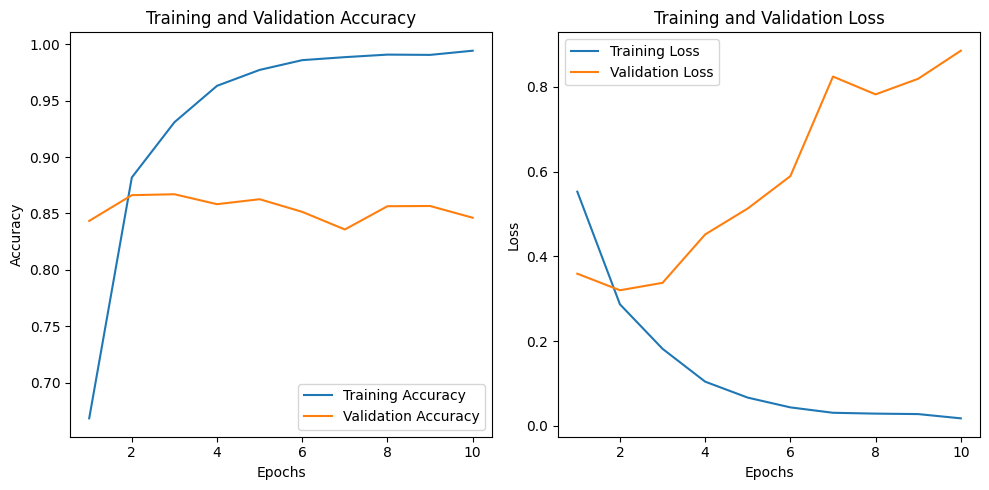

Final Training Accuracy: 0.9941
Final Validation Accuracy: 0.8462
Final Training Loss: 0.0177
Final Validation Loss: 0.8850


In [ ]:
plot_history(history, tps)

Le temps de calcul est 224s.Il s'agit du double du CNN à deux couches.

---

Il n'y a pas d'améliroation significatives, ni pour le sur apprentissage, no pour le score de précisions sur les données de validation.

# Optimisation des paramêtres

Nous effectuons une optimisation bayésienne avec l'architecture la plus prometeuse pour chacun des modèles.

On utilise l'earlystop afin de minimiser les chances d'overfitting.

Les hyperparamètres que l'on optimise ici sont :


*   Le learning rate
*   Le taux de dropout
*   Les unités de chacune des couches LSTM/GRU/RNN,...
*   Les unités de la couche dense éventuelle



## RNN

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)  # Dropout
    rnn1 = trial.suggest_int("rnn1", 64, 512, step=64)  # Taille première LSTM
    dim_dense = trial.suggest_int("dim_dense", 64, 512, step=64)  # Taille couche Dense
    dim_embed = trial.suggest_int("dim_embed", 150, 400, step=50)  # Taille couche Dense


    # Définition du modèle RNN
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim_embed, input_length=max_length),
        SimpleRNN(rnn1, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dim_dense, activation='relu'),  # Couche Dense avec activation ReLU
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study_rnn = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study_rnn.optimize(objective, n_trials=10)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study_rnn.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study_rnn.best_value)


[I 2024-12-20 06:41:55,495] A new study created in memory with name: no-name-d47815b8-828e-4d8a-8457-6b7a69d24924
<ipython-input-46-2d8c5707d47c>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-46-2d8c5707d47c>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-20 06:44:34,234] Trial 0 finished with value: 0.5103999972343445 and parameters: {'l

Meilleurs hyperparamètres : {'learning_rate': 1.265451366281986e-05, 'dropout_rate': 0.28071448457300163, 'rnn1': 512, 'dim_dense': 192, 'dim_embed': 350}
Meilleure accuracy de validation : 0.7824000120162964


In [ ]:
# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = {'learning_rate': 1.265451366281986e-05, 'dropout_rate': 0.28071448457300163, 'rnn1': 512, 'dim_dense': 192, 'dim_embed': 350}

# Création du modèle avec les meilleurs paramètres
mod_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['dim_embed'], input_length=max_length),
    SimpleRNN(best_params['rnn1'], return_sequences=False),
    Dense(best_params['dim_dense'], activation='relu'),  # Couche Dense avec activation ReLU
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

# Compilation avec le learning rate optimisé
mod_rnn.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = mod_rnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
)
mod_rnn.save('/content/drive/Mydrive/Projet_HDDL/mod_rnn.h5')
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = mod_rnn.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.5170 - loss: 0.6943 - val_accuracy: 0.5066 - val_loss: 0.6936
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.5389 - loss: 0.6875 - val_accuracy: 0.5290 - val_loss: 0.6915
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.5955 - loss: 0.6703 - val_accuracy: 0.6744 - val_loss: 0.6158
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.7131 - loss: 0.5826 - val_accuracy: 0.6906 - val_loss: 0.6026
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.7717 - loss: 0.5094 - val_accuracy: 0.7430 - val_loss: 0.5319
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8177 - loss: 0.4331 - val_accuracy: 0.7668 - val_loss: 0.5020
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.8473 - loss: 0.3816 - val_accuracy: 0.7480 - val_loss: 0.5444
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.8641 - loss: 0.3501 - val_accurac

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7638 - loss: 0.5453
Test Accuracy : 0.7698
Test Loss : 0.5227


Training time: 0


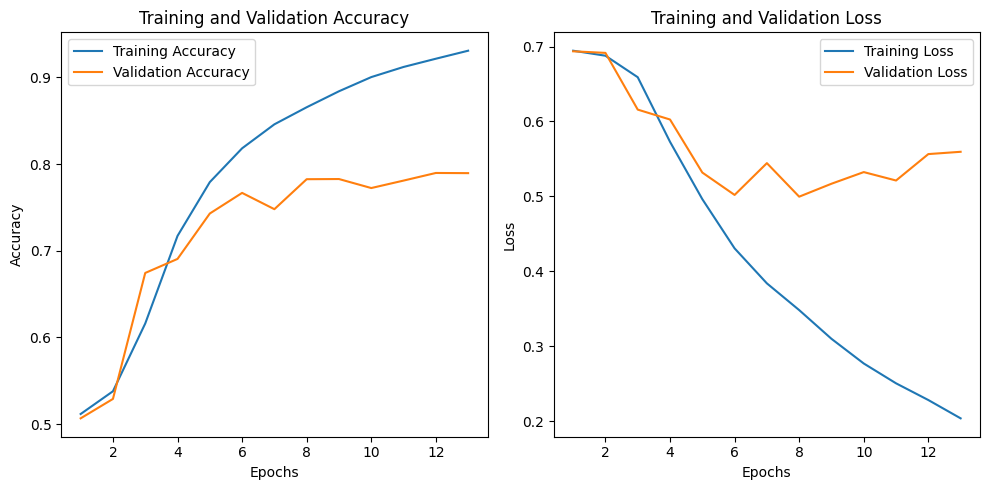

Final Training Accuracy: 0.9309
Final Validation Accuracy: 0.7896
Final Training Loss: 0.2039
Final Validation Loss: 0.5595


In [ ]:
plot_history(history, 0)

## LSTM

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    dim_lstm1 = trial.suggest_int("dim_lstm1", 128, 512, step=64)  # Taille première LSTM
    dim_dense = trial.suggest_int("dim_dense", 128, 512, step=64)  # Taille couche Dense
    dim_embed = trial.suggest_int("dim_embed", 150, 400, step=50)  # Taille couche Dense



    # Définition du modèle RNN
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim_embed, input_length=max_length),
        LSTM(dim_lstm1, return_sequences=False),  # Première couche LSTM
        Dropout(dropout_rate),
        Dense(dim_dense, activation='relu'),  # Couche Dense
        Dense(1, activation='sigmoid')  # Couche de sortie
    ])


    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study_lstm = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study_lstm.optimize(objective, n_trials=10)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study_lstm.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study_lstm.best_value)


[I 2024-12-20 07:31:18,009] A new study created in memory with name: no-name-c5f5274d-5fbb-4883-a421-2ee8a304bfb7
<ipython-input-28-ab17de0fec95>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-28-ab17de0fec95>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-20 07:33:05,130] Trial 0 finished with value: 0.6420000195503235 and parameters: {'l

Meilleurs hyperparamètres : {'learning_rate': 2.0981215588131333e-05, 'dropout_rate': 0.3767225363193716, 'dim_lstm1': 384, 'dim_dense': 384, 'dim_embed': 300}
Meilleure accuracy de validation : 0.8772000074386597


In [ ]:
# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = {'learning_rate': 2.0981215588131333e-05, 'dropout_rate': 0.3767225363193716, 'dim_lstm1': 384, 'dim_dense': 384, 'dim_embed': 300}

# Création du modèle avec les meilleurs paramètres
    # Définition du modèle RNN
mod_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['dim_embed'], input_length=max_length),
    LSTM(best_params['dim_lstm1'], return_sequences=False),  # Première couche LSTM
    Dropout(best_params['dropout_rate']),
    Dense(best_params['dim_dense'], activation='relu'),  # Couche Dense
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec le learning rate optimisé
mod_lstm.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = mod_lstm.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
)
mod_lstm.save('/content/drive/MyDrive/Projet_HDDL/mod_lstm.h5')
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = mod_lstm.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5105 - loss: 0.6930 - val_accuracy: 0.5096 - val_loss: 0.6930
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5039 - loss: 0.6930 - val_accuracy: 0.5092 - val_loss: 0.6932
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5060 - loss: 0.6928 - val_accuracy: 0.5096 - val_loss: 0.6930
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5181 - loss: 0.6918 - val_accuracy: 0.5118 - val_loss: 0.6916
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5146 - loss: 0.6910 - val_accuracy: 0.5192 - val_loss: 0.6882
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5662 - loss: 0.6676 - val_accuracy: 0.8252 - val_loss: 0.4134
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8537 - loss: 0.3633 - val_accuracy: 0.8418 - val_loss: 0.4088
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8909 - loss: 0.2860 - 

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8421 - loss: 0.3640
Test Accuracy : 0.8532
Test Loss : 0.3474


Training time: 0


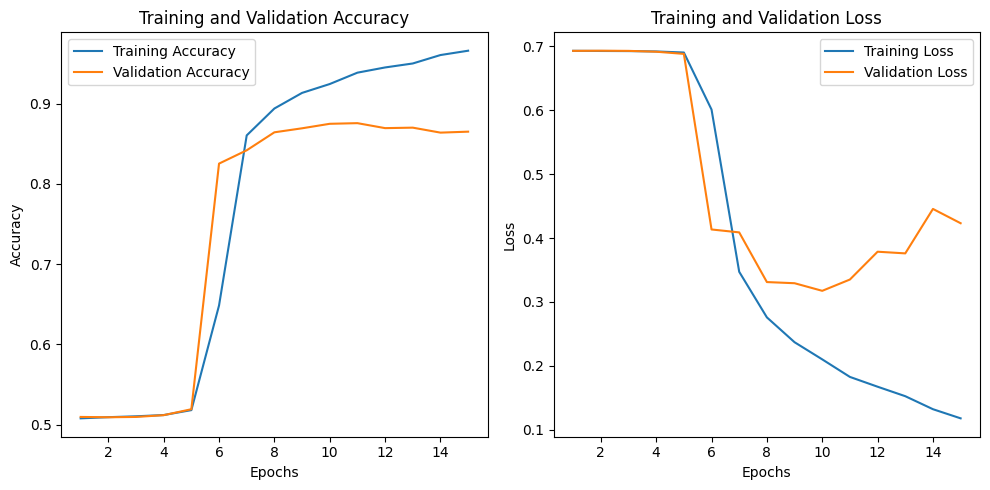

Final Training Accuracy: 0.9658
Final Validation Accuracy: 0.8650
Final Training Loss: 0.1177
Final Validation Loss: 0.4232


In [ ]:
plot_history(history, 0)

## GRU

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    dim_gru1 = trial.suggest_int("dim_gru1", 128, 512, step=64)  # Taille première LSTM
    dim_dense = trial.suggest_int("dim_dense", 128, 512, step=64)  # Taille couche Dense
    dim_embed = trial.suggest_int("dim_embed", 150, 400, step=50)  # Taille couche Dense


    # Définition du modèle RNN
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim_embed, input_length=max_length),
        GRU(dim_gru1, return_sequences=False),  # Première couche LSTM
        Dropout(dropout_rate),
        Dense(dim_dense, activation='relu'),  # Couche Dense
        Dense(1, activation='sigmoid')  # Couche de sortie
    ])


    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study_gru = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study_gru.optimize(objective, n_trials=10)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study_gru.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study_gru.best_value)


[I 2024-12-20 08:04:09,678] A new study created in memory with name: no-name-1d26602a-c629-4d3c-9a6e-68b0c30d0cca
<ipython-input-33-c67b9be7c9cf>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-33-c67b9be7c9cf>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
[I 2024-12-20 08:07:05,786] Trial 0 finished with value: 0.8557999730110168 and parameters: {'learning_rate': 6.122089130709093e-05, 'dropout_rate': 0.3270472184846379, 'dim_gru1': 448, 'dim_dense': 192, 'dim_embed': 300}. Best is trial 0 with value: 0.855799

Meilleurs hyperparamètres : {'learning_rate': 0.000594649623509427, 'dropout_rate': 0.48765499276738716, 'dim_gru1': 448, 'dim_dense': 128, 'dim_embed': 200}
Meilleure accuracy de validation : 0.8593999743461609


In [ ]:
# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = {'learning_rate': 0.000594649623509427, 'dropout_rate': 0.48765499276738716, 'dim_gru1': 448, 'dim_dense': 128, 'dim_embed': 200}

# Création du modèle avec les meilleurs paramètres
    # Définition du modèle RNN
mod_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['dim_embed'], input_length=max_length),
    GRU(best_params['dim_gru1'], return_sequences=False),  # Première couche LSTM
    Dropout(best_params['dropout_rate']),
    Dense(best_params['dim_dense'], activation='relu'),  # Couche Dense
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec le learning rate optimisé
mod_gru.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = mod_gru.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
mod_gru.save('/content/drive/MyDrive/Projet_HDDL/mod_gru.h5')


# Évaluation sur l'ensemble de test
test_loss, test_accuracy = mod_gru.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4933 - loss: 0.6943 - val_accuracy: 0.5140 - val_loss: 0.6911
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5058 - loss: 0.7008 - val_accuracy: 0.5182 - val_loss: 0.6898
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5402 - loss: 0.6690 - val_accuracy: 0.5238 - val_loss: 0.7054
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7066 - loss: 0.5356 - val_accuracy: 0.8638 - val_loss: 0.3716
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9170 - loss: 0.2231 - val_accuracy: 0.8600 - val_loss: 0.3772
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9600 - loss: 0.1198 - val_accuracy: 0.8438 - val_loss: 0.4299
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9804 - loss: 0.0679 - val_accuracy: 0.8448 - val_loss: 0.5392
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9902 - loss: 0.0390 - 

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8395 - loss: 0.4633
Test Accuracy : 0.8532
Test Loss : 0.3814


Training time: 0


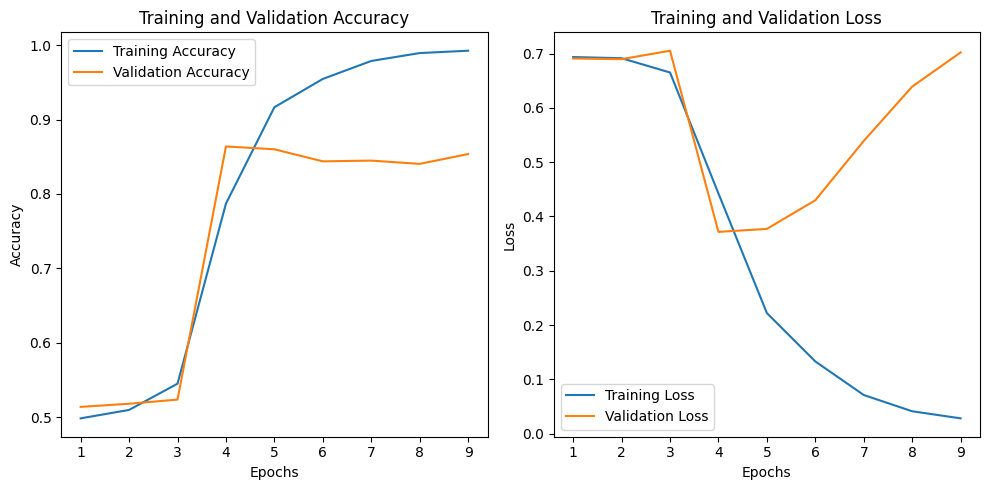

Final Training Accuracy: 0.9924
Final Validation Accuracy: 0.8536
Final Training Loss: 0.0282
Final Validation Loss: 0.7022


In [ ]:
plot_history(history, 0)

## MLP

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    dim_dense1 = trial.suggest_int("dim_dense1", 128, 512, step=64)  # Taille première LSTM
    dim_dense2 = trial.suggest_int("dim_dense2", 128, 512, step=64)  # Taille première LSTM
    dim_embed = trial.suggest_int("dim_embed", 150, 400, step=50)  # Taille couche Dense



    model_mlp = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim_embed, input_length=max_length),
        Flatten(),  # Aplatissement des embeddings
        Dense(dim_dense1, activation='relu'),
        Dense(dim_dense2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
    ])


    # Compilation
    model_mlp.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model_mlp.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study_mlp = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study_mlp.optimize(objective, n_trials=10)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study_mlp.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study_mlp.best_value)


[I 2024-12-20 08:35:10,760] A new study created in memory with name: no-name-189ff7e3-602c-4dc2-b557-3933edaa1651


Epoch 1/10


<ipython-input-38-e4197095d981>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-38-e4197095d981>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5509 - loss: 0.6693 - val_accuracy: 0.8486 - val_loss: 0.3515
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9223 - loss: 0.2067 - val_accuracy: 0.8586 - val_loss: 0.3525
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9919 - loss: 0.0393 - val_accuracy: 0.8432 - val_loss: 0.4745
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9992 - loss: 0.0060 - val_accuracy: 0.8446 - val_loss: 0.5633
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.8446 - val_loss: 0.6165
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9999 - loss: 6.8435e-04 - val_accuracy: 0.8450 - val_loss: 0.6564


[I 2024-12-20 08:35:28,872] Trial 0 finished with value: 0.8586000204086304 and parameters: {'learning_rate': 0.0002258206695223057, 'dropout_rate': 0.4456040065315299, 'dim_dense1': 192, 'dim_dense2': 192, 'dim_embed': 200}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5031 - loss: 0.6930 - val_accuracy: 0.5344 - val_loss: 0.6908
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5774 - loss: 0.6837 - val_accuracy: 0.6364 - val_loss: 0.6548
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7625 - loss: 0.5720 - val_accuracy: 0.8336 - val_loss: 0.4085
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8980 - loss: 0.2939 - val_accuracy: 0.8490 - val_loss: 0.3533
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9415 - loss: 0.1855 - val_accuracy: 0.8540 - val_loss: 0.3479
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9679 - loss: 0.1183 - val_accuracy: 0.8550 - val_loss: 0.3544
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9841 - loss: 0.0742 - val_accuracy: 0.8528 - val_loss: 0.3786
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9918 - loss: 0.0477 - val_accuracy: 0

[I 2024-12-20 08:35:50,081] Trial 1 finished with value: 0.8550000190734863 and parameters: {'learning_rate': 3.409041856802399e-05, 'dropout_rate': 0.3717947690525061, 'dim_dense1': 128, 'dim_dense2': 448, 'dim_embed': 150}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5220 - loss: 0.6926 - val_accuracy: 0.5456 - val_loss: 0.6863
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7067 - loss: 0.5707 - val_accuracy: 0.8534 - val_loss: 0.3514
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9292 - loss: 0.1976 - val_accuracy: 0.8450 - val_loss: 0.3637
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9795 - loss: 0.0858 - val_accuracy: 0.8556 - val_loss: 0.3659
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9960 - loss: 0.0309 - val_accuracy: 0.8520 - val_loss: 0.4160
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9988 - loss: 0.0132 - val_accuracy: 0.8474 - val_loss: 0.4682
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9995 - loss: 0.0061 - val_accuracy: 0.8480 - val_loss: 0.4868


[I 2024-12-20 08:36:07,902] Trial 2 finished with value: 0.8555999994277954 and parameters: {'learning_rate': 7.793430617149678e-05, 'dropout_rate': 0.22522971171120104, 'dim_dense1': 128, 'dim_dense2': 128, 'dim_embed': 200}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5264 - loss: 0.6928 - val_accuracy: 0.6090 - val_loss: 0.6538
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7720 - loss: 0.4849 - val_accuracy: 0.8480 - val_loss: 0.3491
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9680 - loss: 0.1118 - val_accuracy: 0.8480 - val_loss: 0.3866
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9950 - loss: 0.0302 - val_accuracy: 0.8424 - val_loss: 0.4810
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9992 - loss: 0.0083 - val_accuracy: 0.8460 - val_loss: 0.5024
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 0.8476 - val_loss: 0.5409
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.8478 - val_loss: 0.5733


[I 2024-12-20 08:36:47,878] Trial 3 finished with value: 0.8479999899864197 and parameters: {'learning_rate': 7.056804839159454e-05, 'dropout_rate': 0.35800047673299806, 'dim_dense1': 384, 'dim_dense2': 448, 'dim_embed': 350}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5125 - loss: 0.6932 - val_accuracy: 0.5240 - val_loss: 0.6899
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5769 - loss: 0.6774 - val_accuracy: 0.6906 - val_loss: 0.6146
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8140 - loss: 0.4825 - val_accuracy: 0.8414 - val_loss: 0.3720
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9292 - loss: 0.2192 - val_accuracy: 0.8472 - val_loss: 0.3516
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9611 - loss: 0.1305 - val_accuracy: 0.8558 - val_loss: 0.3488
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9890 - loss: 0.0635 - val_accuracy: 0.8456 - val_loss: 0.3916
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9925 - loss: 0.0429 - val_accuracy: 0.8576 - val_loss: 0.3946
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9983 - loss: 0.0198 - val_accuracy: 0

[I 2024-12-20 08:37:15,032] Trial 4 finished with value: 0.8575999736785889 and parameters: {'learning_rate': 3.700886383726651e-05, 'dropout_rate': 0.45508869472021896, 'dim_dense1': 256, 'dim_dense2': 320, 'dim_embed': 200}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5131 - loss: 0.6926 - val_accuracy: 0.5362 - val_loss: 0.6891
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5798 - loss: 0.6792 - val_accuracy: 0.5554 - val_loss: 0.6760
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7146 - loss: 0.6119 - val_accuracy: 0.7792 - val_loss: 0.5128
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8760 - loss: 0.3790 - val_accuracy: 0.8038 - val_loss: 0.4227
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9265 - loss: 0.2301 - val_accuracy: 0.8418 - val_loss: 0.3705
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9619 - loss: 0.1474 - val_accuracy: 0.8242 - val_loss: 0.4055
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9787 - loss: 0.0987 - val_accuracy: 0.8406 - val_loss: 0.3783
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9890 - loss: 0.0657 - val_accurac

[I 2024-12-20 08:38:04,458] Trial 5 finished with value: 0.847599983215332 and parameters: {'learning_rate': 1.7049939125550535e-05, 'dropout_rate': 0.2869811107274407, 'dim_dense1': 384, 'dim_dense2': 512, 'dim_embed': 300}. Best is trial 0 with value: 0.8586000204086304.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6583 - loss: 0.5716 - val_accuracy: 0.8690 - val_loss: 0.3112
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9698 - loss: 0.0891 - val_accuracy: 0.8456 - val_loss: 0.4470
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.8450 - val_loss: 0.6494
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.8504 - val_loss: 0.8057
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 1.0000 - loss: 8.9815e-05 - val_accuracy: 0.8508 - val_loss: 0.8783
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 2.3011e-05 - val_accuracy: 0.8500 - val_loss: 0.9155


[I 2024-12-20 08:38:23,922] Trial 6 finished with value: 0.8690000176429749 and parameters: {'learning_rate': 0.0008522222914510424, 'dropout_rate': 0.2708843738541907, 'dim_dense1': 448, 'dim_dense2': 320, 'dim_embed': 150}. Best is trial 6 with value: 0.8690000176429749.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5087 - loss: 0.6937 - val_accuracy: 0.5186 - val_loss: 0.6916
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5784 - loss: 0.6803 - val_accuracy: 0.5844 - val_loss: 0.6751
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6930 - loss: 0.6230 - val_accuracy: 0.7778 - val_loss: 0.5452
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8653 - loss: 0.4108 - val_accuracy: 0.8254 - val_loss: 0.4035
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9238 - loss: 0.2384 - val_accuracy: 0.8440 - val_loss: 0.3631
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9577 - loss: 0.1577 - val_accuracy: 0.8474 - val_loss: 0.3563
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9763 - loss: 0.1005 - val_accuracy: 0.8466 - val_loss: 0.3660
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9895 - loss: 0.0641 - val_acc

[I 2024-12-20 08:39:16,137] Trial 7 finished with value: 0.8511999845504761 and parameters: {'learning_rate': 1.912692858601257e-05, 'dropout_rate': 0.4937035591141037, 'dim_dense1': 512, 'dim_dense2': 192, 'dim_embed': 350}. Best is trial 6 with value: 0.8690000176429749.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5146 - loss: 0.6931 - val_accuracy: 0.5272 - val_loss: 0.6914
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5924 - loss: 0.6751 - val_accuracy: 0.6376 - val_loss: 0.6603
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7384 - loss: 0.5827 - val_accuracy: 0.8052 - val_loss: 0.4657
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8929 - loss: 0.3273 - val_accuracy: 0.8376 - val_loss: 0.3765
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9401 - loss: 0.1965 - val_accuracy: 0.8280 - val_loss: 0.3865
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9707 - loss: 0.1208 - val_accuracy: 0.8500 - val_loss: 0.3622
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9863 - loss: 0.0734 - val_accuracy: 0.8466 - val_loss: 0.3756
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9939 - loss: 0.0460 - val_acc

[I 2024-12-20 08:40:08,904] Trial 8 finished with value: 0.8500000238418579 and parameters: {'learning_rate': 2.072823759215995e-05, 'dropout_rate': 0.4316301413286016, 'dim_dense1': 512, 'dim_dense2': 256, 'dim_embed': 300}. Best is trial 6 with value: 0.8690000176429749.


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5456 - loss: 0.6783 - val_accuracy: 0.8306 - val_loss: 0.3858
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9105 - loss: 0.2336 - val_accuracy: 0.8488 - val_loss: 0.3612
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9895 - loss: 0.0453 - val_accuracy: 0.8366 - val_loss: 0.4786
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9988 - loss: 0.0080 - val_accuracy: 0.8394 - val_loss: 0.5874
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8430 - val_loss: 0.6403
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 5.2252e-04 - val_accuracy: 0.8414 - val_loss: 0.6837
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 2.9105e-04 - val_accuracy: 0.8428 - val_loss: 0.7221


[I 2024-12-20 08:40:35,219] Trial 9 finished with value: 0.848800003528595 and parameters: {'learning_rate': 0.0001584542793909699, 'dropout_rate': 0.4057580040695167, 'dim_dense1': 512, 'dim_dense2': 512, 'dim_embed': 150}. Best is trial 6 with value: 0.8690000176429749.


Meilleurs hyperparamètres : {'learning_rate': 0.0008522222914510424, 'dropout_rate': 0.2708843738541907, 'dim_dense1': 448, 'dim_dense2': 320, 'dim_embed': 150}
Meilleure accuracy de validation : 0.8690000176429749


In [38]:
# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = {'learning_rate': 0.0008522222914510424, 'dropout_rate': 0.2708843738541907, 'dim_dense1': 448, 'dim_dense2': 320, 'dim_embed': 150}

# Création du modèle avec les meilleurs paramètres
# Définition du modèle RNN
mod_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['dim_embed'], input_length=max_length),
    Flatten(),  # Aplatissement des embeddings
    Dense(best_params['dim_dense1'], activation='relu'),
    Dense(best_params['dim_dense2'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])


# Compilation avec le learning rate optimisé
mod_mlp.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = mod_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


mod_mlp.save('/content/drive/MyDrive/Projet_HDDL/mod_mlp_opt.h5')

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = mod_mlp.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6950 - loss: 0.5408 - val_accuracy: 0.8624 - val_loss: 0.3291
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9774 - loss: 0.0710 - val_accuracy: 0.8362 - val_loss: 0.5179
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.8376 - val_loss: 0.8472
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.8312 - val_loss: 0.9399
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9968 - loss: 0.0082 - val_accuracy: 0.8288 - val_loss: 0.7827
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9953 - loss: 0.0133 - val_accuracy: 0.8390 - val_loss: 0.8981


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8156 - loss: 0.4239
Test Accuracy : 0.8464
Test Loss : 0.3517


Training time: 0


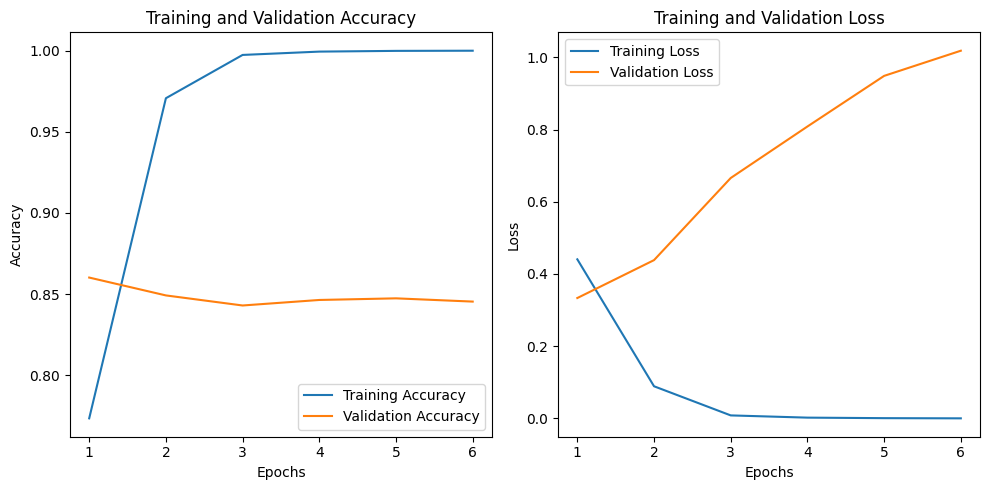

Final Training Accuracy: 0.9999
Final Validation Accuracy: 0.8454
Final Training Loss: 0.0003
Final Validation Loss: 1.0183


In [36]:
plot_history(history, 0)

## CNN

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    dim_conv1 = trial.suggest_int("dim_conv1", 128, 512, step=64)  # Taille première LSTM
    dim_conv2 = trial.suggest_int("dim_conv2", 128, 512, step=64)  # Taille première LSTM
    dim_dense = trial.suggest_int("dim_dense", 128, 512, step=64)  # Taille couche Dense
    dim_embed = trial.suggest_int("dim_embed", 150, 400, step=50)  # Taille couche Dense



    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=dim_embed),
        Conv1D(filters=dim_conv1, kernel_size=3, activation='relu'),
        Conv1D(filters=dim_conv2, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),  # Réduction des dimensions avec GlobalMaxPooling1D
        Dropout(dropout_rate),

        Dense(dim_dense, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study_cnn = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study_cnn.optimize(objective, n_trials=10)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study_cnn.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study_cnn.best_value)


[I 2024-12-20 08:44:03,718] A new study created in memory with name: no-name-05eb0dcf-83ce-4a4f-986c-71dbc10faf6c
<ipython-input-45-fc4fc3558886>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-45-fc4fc3558886>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
[I 2024-12-20 08:46:17,118] Trial 0 finished with value: 0.8633999824523926 and parameters: {'learning_rate': 0.0009517908736762696, 'dropout_rate': 0.4522497865149549, 'dim_conv1': 512, 'dim_conv2': 384, 'dim_dense': 512, 'dim_embed': 400}. Best is trial 0 w

In [27]:
# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = {'learning_rate': 0.0009517908736762696, 'dropout_rate': 0.4522497865149549, 'dim_conv1': 512, 'dim_conv2': 384, 'dim_dense': 512, 'dim_embed': 400}

# Création du modèle avec les meilleurs paramètres
# Définition du modèle RNN
mod_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=best_params['dim_embed']),
    Conv1D(filters=best_params['dim_conv1'], kernel_size=3, activation='relu'),
    Conv1D(filters=best_params['dim_conv2'], kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),  # Réduction des dimensions avec GlobalMaxPooling1D
    Dropout(best_params['dropout_rate']),

    Dense(best_params['dim_dense'], activation='relu'),
    Dense(1, activation='sigmoid')
])



# Compilation avec le learning rate optimisé
mod_cnn.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = mod_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


mod_cnn.save('/content/drive/MyDrive/Projet_HDDL/mod_cnn.h5')

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = mod_cnn.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6925 - loss: 0.5499 - val_accuracy: 0.8478 - val_loss: 0.3503
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9077 - loss: 0.2368 - val_accuracy: 0.8574 - val_loss: 0.3360
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9590 - loss: 0.1104 - val_accuracy: 0.8466 - val_loss: 0.4449
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9806 - loss: 0.0550 - val_accuracy: 0.8444 - val_loss: 0.5144
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9875 - loss: 0.0398 - val_accuracy: 0.8472 - val_loss: 0.7222


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8382 - loss: 0.3602
Test Accuracy : 0.8485
Test Loss : 0.3458


Training time: 0


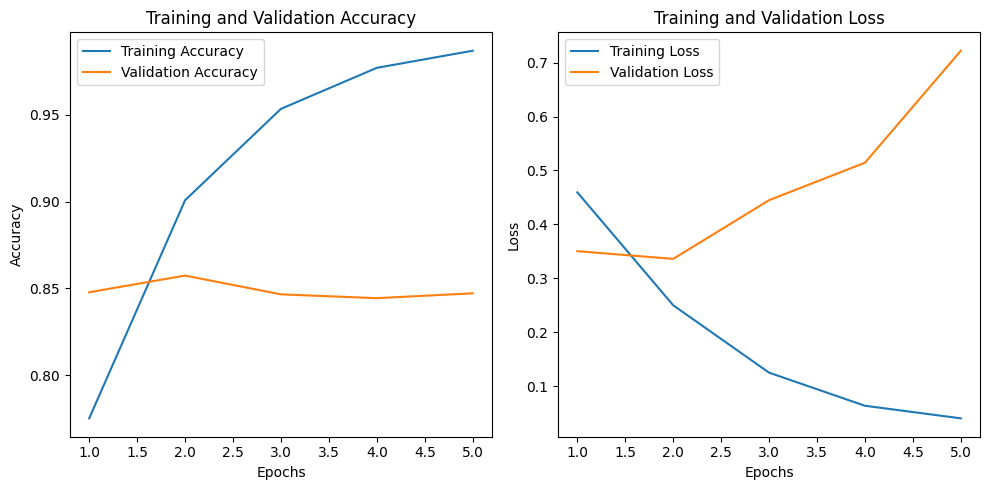

Final Training Accuracy: 0.9868
Final Validation Accuracy: 0.8472
Final Training Loss: 0.0402
Final Validation Loss: 0.7222


In [28]:
plot_history(history, 0)

## Synthèse

Les meilleurs paramêtres ont été déterminés pour tous les modèles, on remarque qu'il n'y a que peut d'amelioration mise à part RNN

# Construction de l'ensemble par vote majoritaire

Création d'un ensemble (ensemble model)

- **Fusion des modèles via vote majoritaire** :
  - On ne fusionne pas directement les architectures en un seul réseau (pas d'empilement).
  - Chaque modèle prédit indépendamment une classe (0 ou 1) pour un échantillon donné.
  - Les prédictions des 5 modèles déjà entraînés sont combinées par un **vote majoritaire** pour déterminer la prédiction finale.

Comparaison des performances

- Une fois l'ensemble créé, on compare ses performances avec celles des modèles individuels.
- L'objectif est de vérifier si l'**ensemble** améliore les résultats par rapport à l'utilisation d'un seul modèle.


In [39]:
# Charger les modèles avec des noms descriptifs
models = {
    "RNN": load_model('/content/drive/MyDrive/mod_rnn.h5'),
    "LSTM": load_model('/content/drive/MyDrive/mod_lstm.h5'),
    "GRU": load_model('/content/drive/MyDrive/mod_gru.h5'),
    "MLP": load_model('/content/drive/MyDrive/mod_mlp_opt.h5'),
    "CNN": load_model('/content/drive/MyDrive/mod_cnn.h5'),
}

In [40]:
# Prédictions pour chaque modèle
predictions = {}
for model_name, model in models.items():
    print(f"Prédiction pour le modèle {model_name}...")
    predictions[model_name] = model.predict(test_padded)

# Convertir les probabilités en classes binaires (0 ou 1)
predictions_classes = {model_name: np.round(pred).astype(int) for model_name, pred in predictions.items()}

Prédiction pour le modèle RNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Prédiction pour le modèle LSTM...
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
Prédiction pour le modèle GRU...
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
Prédiction pour le modèle MLP...
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Prédiction pour le modèle CNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [41]:
# Appliquer le vote majoritaire strict
# Empiler les prédictions (num_samples, num_models)
predictions_stack = np.stack(list(predictions_classes.values()), axis=-1)

# Compter les prédictions pour chaque classe (0 et 1)
count_0 = np.sum(predictions_stack == 0, axis=-1)
count_1 = np.sum(predictions_stack == 1, axis=-1)

# Comparer les counts pour déterminer la classe majoritaire
ensemble_predictions = np.where(count_1 > count_0, 1, 0)


In [45]:
# Évaluer l'ensemble
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f"Accuracy de l'ensemble (vote majoritaire) : {ensemble_accuracy:.4f}")

# Rapport de classification pour l'ensemble
report_ensemble = classification_report(test_labels, ensemble_predictions, target_names=["Négatif", "Positif"])
print("Rapport de classification de l'ensemble :\n", report_ensemble)



Accuracy de l'ensemble (vote majoritaire) : 0.8682
Rapport de classification de l'ensemble :
               precision    recall  f1-score   support

     Négatif       0.85      0.89      0.87     12500
     Positif       0.88      0.85      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



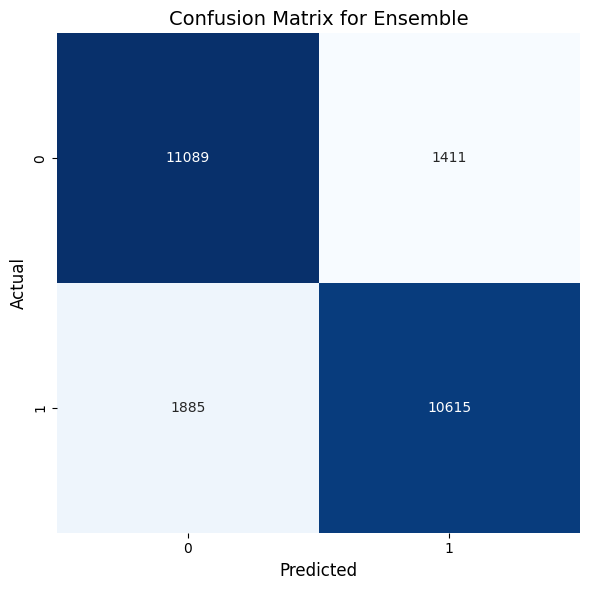

In [51]:
# Calculer la matrice de confusion
conf_matrix_ensemble = confusion_matrix(test_labels, ensemble_predictions)

# Créer une figure avec des sous-graphiques (1x1 ici, mais vous pouvez ajuster pour plusieurs modèles)
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Affichage de la matrice de confusion avec Seaborn
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='g', ax=axes, cmap='Blues', cbar=False)

# Ajouter des titres et des étiquettes
axes.set_title('Confusion Matrix for Ensemble', fontsize=14)
axes.set_xlabel('Predicted', fontsize=12)
axes.set_ylabel('Actual', fontsize=12)

# Afficher la figure
plt.tight_layout()
plt.show()


Évaluation pour le modèle RNN :
Accuracy : 0.7698
              precision    recall  f1-score   support

     Négatif       0.77      0.78      0.77     12500
     Positif       0.77      0.76      0.77     12500

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000

Matrice de confusion :
 [[9688 2812]
 [2943 9557]]


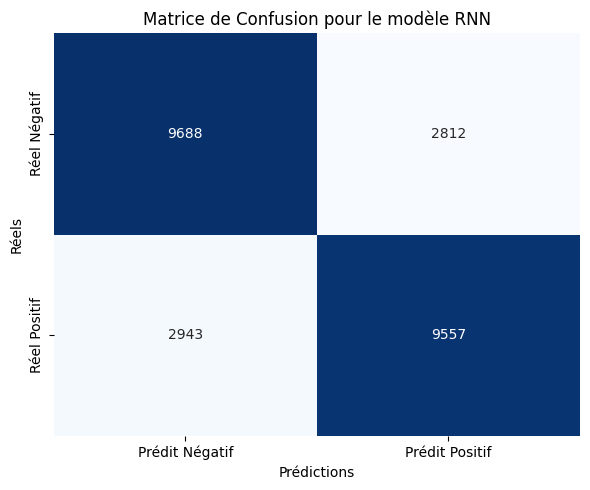


Évaluation pour le modèle LSTM :
Accuracy : 0.8532
              precision    recall  f1-score   support

     Négatif       0.84      0.87      0.86     12500
     Positif       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Matrice de confusion :
 [[10843  1657]
 [ 2012 10488]]


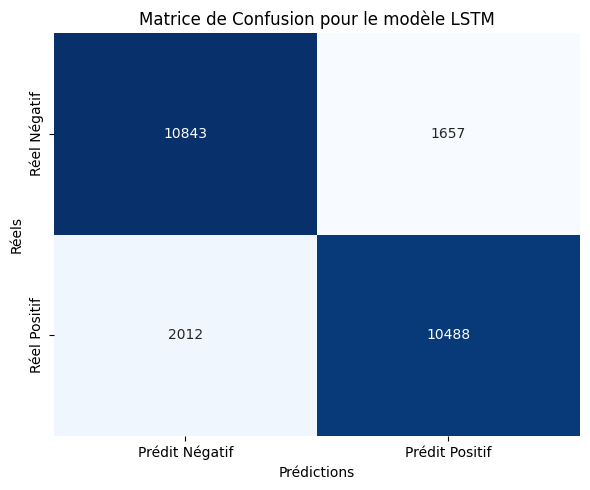


Évaluation pour le modèle GRU :
Accuracy : 0.8532
              precision    recall  f1-score   support

     Négatif       0.84      0.87      0.86     12500
     Positif       0.87      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Matrice de confusion :
 [[10870  1630]
 [ 2040 10460]]


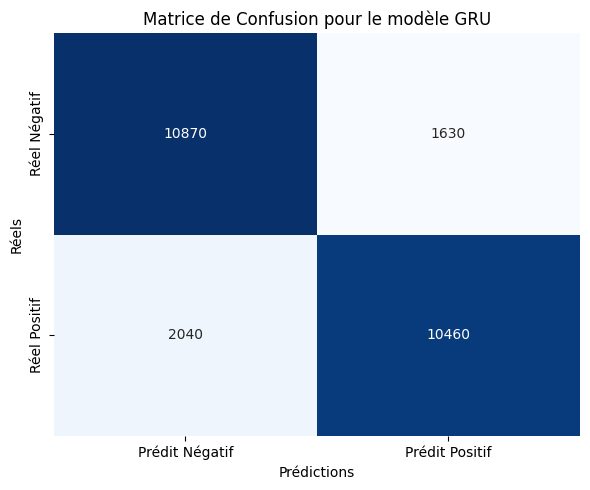


Évaluation pour le modèle MLP :
Accuracy : 0.8464
              precision    recall  f1-score   support

     Négatif       0.82      0.89      0.85     12500
     Positif       0.88      0.80      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Matrice de confusion :
 [[11130  1370]
 [ 2470 10030]]


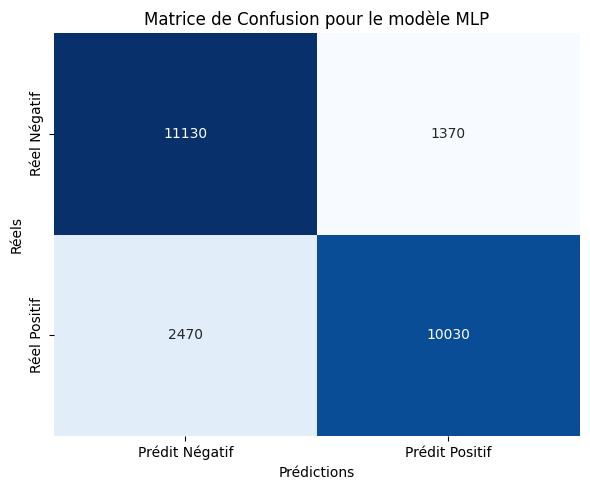


Évaluation pour le modèle CNN :
Accuracy : 0.8485
              precision    recall  f1-score   support

     Négatif       0.84      0.86      0.85     12500
     Positif       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Matrice de confusion :
 [[10761  1739]
 [ 2049 10451]]


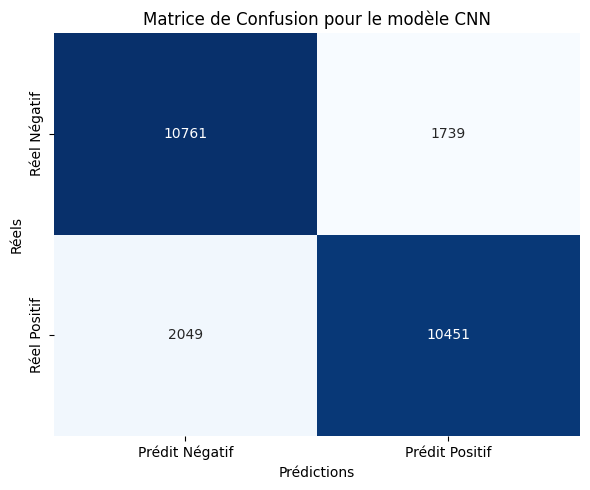

In [52]:
# Évaluer les modèles individuels
for model_name, pred_classes in predictions_classes.items():
    print(f"\nÉvaluation pour le modèle {model_name} :")

    # Calculer et afficher la précision
    accuracy = accuracy_score(test_labels, pred_classes)
    print(f"Accuracy : {accuracy:.4f}")

    # Générer le rapport de classification
    report = classification_report(test_labels, pred_classes, target_names=["Négatif", "Positif"])
    print(report)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(test_labels, pred_classes)
    print("Matrice de confusion :\n", conf_matrix)

    # Affichage de la matrice de confusion avec Seaborn
    plt.figure(figsize=(6, 5))  # Définir la taille de la figure
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=["Prédit Négatif", "Prédit Positif"],
                yticklabels=["Réel Négatif", "Réel Positif"])

    # Ajouter des titres et des étiquettes
    plt.title(f'Matrice de Confusion pour le modèle {model_name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Réels')

    # Afficher la figure
    plt.tight_layout()
    plt.show()


La fusion par vote majoritaire n'augmente pas les résultats bien que nos modèles soient tous les 5 perforamnts. Cela signifie qu'ils se trompent en majorité sur les même choses, c'est pourquoi ils ne peuvent pas se "compenser".

# Exploration de piste d'amélioration

### Utilisation d'Embeddings pré-entrainés

L’utilisation d’embeddings pré-entraînés, comme **GloVe**, peut être très bénéfique ici. **Global Vectors for Word Representation** est un modèle pré-entraîné qui capture les relations sémantiques et transforme les mots en vecteurs numériques. Les embeddings GloVe ont été appris à partir de vastes corpus comme Wikipédia, et garantissent une représentation riche et générale du language.

GloVe se base sur les cooccurrences globales des mots dans un corpus : il détecte combien de fois deux mots apparaissent ensemble dans un même contexte donné. Il capture à la fois les relations locales et globales entre les mots.

Utiliser des embeddings pré entrainés permettra d'exploiter une compréhension initiales des relations entre les mots, sans réapprendre de zéro. Ils permettent généralement d'obtenir de meilleurs résultats sur les données de validation, tout particulièrement sur des datasets de taille modérée comme le nôtre.


Nous décidons ici d'utiliser des embeddings pré entrainés fixes, c'est à dire non entrainables (paramètre *trainable=False*). Cela permet de réduire le risque de surapprentissage. Geler les poids empêche le modèle de modifier les embeddings créés lors de l'entrainement de GloVe.

In [ ]:
import os
import urllib.request
import zipfile

# Créer un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Télécharger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Téléchargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("Téléchargement terminé.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction terminée. Les fichiers sont disponibles dans :", glove_dir)


Téléchargement des embeddings GloVe...
Téléchargement terminé.
Extraction des fichiers GloVe...
Extraction terminée. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.200d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings chargés : {len(embedding_index)}")

# Créer la matrice d'embeddings pour ton vocabulaire
embedding_dim = 200  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succès.")


Nombre d'embeddings chargés : 400000
Matrice d'embeddings GloVe construite avec succès.


In [ ]:
# Initialiser les compteurs
total_words = 0
covered_words = 0

# Parcourir le vocabulaire
for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # On s'assure de rester dans la limite du vocabulaire défini
        total_words += 1
        if word in embedding_index:  # Vérifier si le mot a un vecteur dans les embeddings
            covered_words += 1

# Calcul du taux de couverture
coverage_ratio = covered_words / total_words
print(f"Taux de couverture du vocabulaire : {coverage_ratio * 100:.2f}%")

Taux de couverture du vocabulaire : 98.59%


On remarque que la majorité (98.5%) de notre vocabulaire est bien compris par Glove. Ainsi, la représentation est pertinente pour nos modèles.

In [ ]:
# Construction du modèle
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length
              ),
    LSTM(512, return_sequences=False),  # Une seule couche LSTM
    Dropout(dropout_rate),  # Régularisation pour éviter l'overfitting
    Dense(256, activation='relu'),  # Couche Dense avec activation ReLU
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])


# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
# Compilation avec un learning rate encore plus bas
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
model.summary()
start = time.time()
# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)
end = time.time()
tps = end - start

Training time: 202


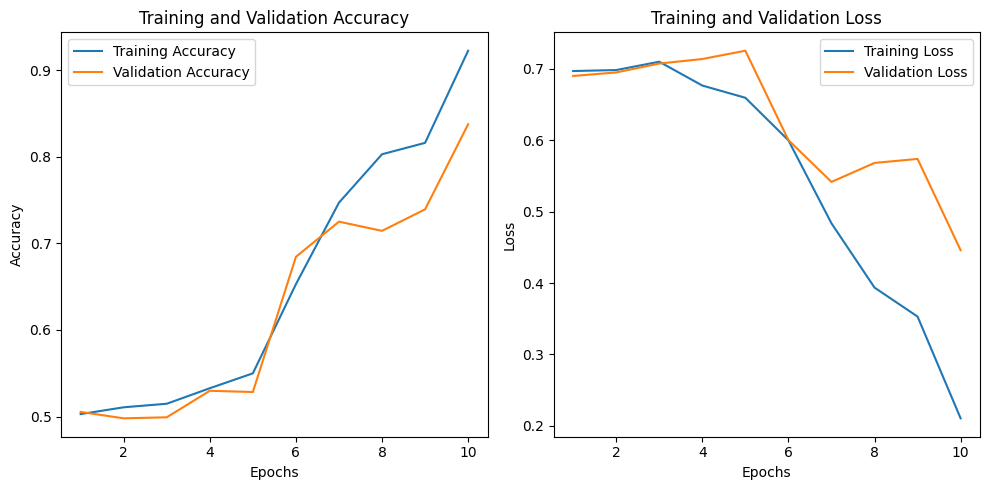

Final Training Accuracy: 0.9223
Final Validation Accuracy: 0.8374
Final Training Loss: 0.2105
Final Validation Loss: 0.4460


In [ ]:
plot_history(history, tps)

Il n'y a pas d'amélioration des perforamnces notables: ceci peut être dû au fait que la dependance séquentielle n'est pas fondamentale dans notre tâche comme le montre les performances de MLP et CNN.

# Bonus

The IMDB dataset contains aditional unlabeled data. Can you
device a way to pre-train the above models on the unlabled data and fine-
tune them for the task of sentiment analysis? Are the results better?

**Principe : Pré-training sur les données non labélisées**

- **Objectif :** Utiliser des données non étiquetées pour extraire des connaissances générales sur la langue avant de fine-tuner sur des données étiquetées.

**Méthode : Masked Language Modeling (MLM)**
- Basée sur un modèle transformeur (ex. : BERT).
- **Processus :**
  - Masquer aléatoirement des tokens dans le texte.
  - Le modèle prédit les tokens masqués à partir du contexte des tokens environnants.
- Permet au modèle de comprendre la structure et la sémantique de la langue.

**Fine-tuning**
- Après pré-entraînement sur des données non étiquetées, fine-tuner le modèle avec les données étiquetées d'IMDB.

**Bénéfices du pré-entraînement sur données non étiquetées**
- Génère des embeddings contextuels plus riches.
- Améliore la généralisation, surtout lorsque les données étiquetées sont limitées.
